<a href="https://colab.research.google.com/github/SicilianoBartolomeo/Human-activity-recognition/blob/main/HAR2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from operator import imod
import pandas as pd
import numpy as np
import tensorflow as tf
import keras as krs
from keras import Sequential
from keras.layers import Flatten, Dense, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPool2D, Conv1D, Bidirectional, LSTM
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import seaborn
from sklearn.model_selection import train_test_split
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler, RobustScaler

In [ ]:
import random
seed=42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
from datetime import datetime


experiment_time = datetime.now().isoformat()
folder_name = str(experiment_time).replace(":","_")[0:19]
folder_name

configuration_file_name = 'configuration.txt'

In [ ]:
dataset_path = 'DatasetUniba.csv'
columns_names = ['user_id', 'activity', 'timestamp', 'x_axis', 'y_axis', 'z_axis']

In [ ]:
X_column_names = ['x_axis','y_axis','z_axis']
y_column_name = 'activity'

In [ ]:
classes_to_consider = ['lying','sitting','standing','walking','ironing']

In [ ]:
classes_to_consider = ['lying','sitting','standing','walking','running',
     'cycling','NordicWalking', 'ascendingStairs', 'descendingStairs',
    'vacuumCleaning','ironing','houseCleaning','ropeJumping']

In [ ]:
classes_to_rename = {
     1:'lying',
     2:'sitting',
     3:'standing',
     4:'walking',
     5:'running',
     6: 'cycling',
     7:'NordicWalking',
     9: 'watchingTV',
     10: 'computerWork',
     11: 'carDriving',
    12: 'ascendingStairs',
    13: 'descendingStairs',
    16:'vacuumCleaning',
    17:'ironing',
    18:'foldingLaundry',
    19:'houseCleaning',
    20:'playingSoccer',
    24:'ropeJumping',
    0:'other'
}

In [ ]:
time_steps_list = [600]
step_list =  [100]
use_magnitude = False
aggregate_falls = True
use_speed=True
use_total_speed=False
use_timestamp=False
use_squared_components=True
use_squared_speed=True
use_sign_speed=False
use_position=False

In [ ]:
leave_one_subject_out = True
stratified_test_set = False
leave_one_subject_out_with_validation_users = False
bilstm_one_subject_out = True

use_stats_in_cnn=False

In [ ]:
save_features = False

In [ ]:
batchsize = 512

In [ ]:
from os import mkdir
mkdir(folder_name)

In [ ]:
config_file = open(folder_name + "/" + configuration_file_name,"a")
config_file.write("dataset: " + dataset_path +
"time_steps_list: " + str(time_steps_list) + 
"\nstep_list:" + str(step_list)+
"\nuse_magnitude: "+str(use_magnitude)+
"\naggregate_falls: "+str(aggregate_falls)+
"\nuse_speed: "+str(use_speed)+
"\nuse_total_speed: "+str(use_total_speed)+
"\nuse_timestamp: "+str(use_timestamp)+
"\nuse_squared_components: "+str(use_squared_components)+
"\nuse_squared_speed: "+str(use_squared_speed)+
"\nuse_sign_speed: "+str(use_sign_speed)+
"\nuse_position: "+str(use_position)
)
config_file.close()

# Caricamento dati

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
%cd gdrive/MyDrive
%ls

/content/gdrive/MyDrive
'Colab Notebooks'/   garbage_dataset/   Protocol/


In [ ]:
def load(dataset_path,id):
  columns=[]
  for i in range(54):
    columns.append(str(i))
  columns
  df = pd.read_csv(dataset_path, names=columns, delim_whitespace=True)
  df=df[['0','1','4','5','6']]
  df = df.rename({'0': 'timestamp', '1': 'activity', '4': 'x_axis',
                 '5': 'y_axis', '6': 'z_axis'}, axis=1) 
  df.insert(0, "user_id", id, True)
  return df

In [ ]:
#dataset_path = '/content/Dataset/subject10'
dataset_path = '/content/gdrive/MyDrive/Protocol/subject10'
path = []
num_user = 9

for i in range(num_user):
  if i != 0:
    path.append(dataset_path + str(i) + '.dat')

In [ ]:
#load data subject by subject
column_names = ['user_id','timestamp', 'activity', 'x_axis','y_axis', 'z_axis']
df = pd.DataFrame(columns=column_names)
i=1
for x in path:
  #pd.concat(df, load(x,i))
  df = pd.concat([df, load(x,i)], ignore_index=True)
  i+=1


In [ ]:
df = df.dropna()

In [ ]:
df.isnull().sum()

user_id      0
timestamp    0
activity     0
x_axis       0
y_axis       0
z_axis       0
dtype: int64

In [ ]:
df.head(10)

,user_id,timestamp,activity,x_axis,y_axis,z_axis
0,1,8.38,0,2.37223,8.60074,3.51048
1,1,8.39,0,2.18837,8.56560,3.66179
2,1,8.40,0,2.37357,8.60107,3.54898
3,1,8.41,0,2.07473,8.52853,3.66021
4,1,8.42,0,2.22936,8.83122,3.70000
5,1,8.43,0,2.29959,8.82929,3.54710
6,1,8.44,0,2.33738,8.82900,3.54767
7,1,8.45,0,2.37142,9.05500,3.39347
8,1,8.46,0,2.33951,9.13251,3.54668
9,1,8.47,0,2.25966,9.09415,3.43015


In [ ]:
df.sample(10)

,user_id,timestamp,activity,x_axis,y_axis,z_axis
487231,2,1113.78,17,-0.060980,4.48886,8.260330
2805388,8,3499.52,5,-36.126600,-19.96090,0.413011
1396167,4,3204.88,6,-16.180100,-2.87364,2.424570
2748889,8,2934.53,6,-4.068320,5.62623,4.655630
2077573,6,2975.53,0,-6.552220,-0.43962,7.256030
365180,1,3660.18,0,-7.126770,5.18626,3.687610
871458,3,486.05,2,-1.388170,9.46534,-4.900530
1906147,6,1261.27,0,-10.614600,2.68141,0.564822
527191,2,1513.38,0,-0.912077,5.03523,-7.688030
2311591,7,1697.57,0,-9.062390,3.13440,1.664190


In [ ]:
df.describe()

,user_id,timestamp,x_axis,y_axis,z_axis
count,970352.000000,970352.000000,970352.000000,970352.000000,970352.000000
mean,9.652475,7486.316867,0.406984,-0.656867,-0.275370
std,5.530966,4343.144385,4.259469,7.203429,4.695829
min,1.000000,0.000000,-56.221443,-61.331863,-58.738260
25%,5.000000,3730.000000,-2.204359,-3.413708,-3.185539
50%,9.000000,7460.000000,0.432485,-0.275161,-0.170318
75%,14.000000,11220.000000,2.824348,1.845646,1.931052
max,19.000000,15115.000000,57.871265,61.735350,52.757180


In [ ]:
df['activity']=df['activity'].apply(lambda x: classes_to_rename[x] if x in classes_to_rename.keys() else x)

In [ ]:
df = df[df['activity'].isin(classes_to_consider)]
df.reset_index(drop=True, inplace=True)

In [ ]:
df['activity'].unique()

array(['lying', 'sitting', 'standing', 'ironing', 'vacuumCleaning',
       'ascendingStairs', 'descendingStairs', 'walking', 'NordicWalking',
       'cycling', 'running', 'ropeJumping'], dtype=object)

In [ ]:
df['activity'].unique()

array(['lying', 'sitting', 'standing', 'walking'], dtype=object)

In [ ]:
df.sample(10)

,user_id,timestamp,activity,x_axis,y_axis,z_axis
44943,1,487.16,sitting,-1.240960,8.877980,1.646510
923421,5,212.69,lying,0.873351,7.309610,6.301960
664344,3,2250.40,walking,-18.894200,0.509918,0.794514
1197465,6,240.11,lying,4.961200,-0.332597,8.120900
1435834,7,113.84,lying,0.441252,4.336330,8.614760
306128,2,713.48,standing,-8.687120,4.598070,0.202355
622096,3,1436.04,vacuumCleaning,-5.058800,8.218130,9.327510
618804,3,1403.10,vacuumCleaning,-9.317980,5.808070,-0.811849
960619,5,654.59,sitting,-1.588380,-9.869250,0.934804
1025310,5,1367.02,vacuumCleaning,-6.158200,8.499380,5.884720


In [ ]:
import math

if use_magnitude:
    df['magnitude'] = np.sqrt(np.power(df['x_axis'],2) + np.power(df['y_axis'],2) + np.power(df['z_axis'],2))
    X_column_names.append('magnitude')
df.sample(10)

,user_id,activity,timestamp,x_axis,y_axis,z_axis
80287,2,Walking,4560,-0.299662,-10.027537,0.869551
244360,6,Hopping,8665,-1.436161,0.074990,0.506077
68534,2,Jogging,1290,0.512122,-19.916449,1.170201
569240,15,Hopping,2560,1.413376,7.428269,0.282830
478365,12,Walking,1170,0.966936,7.791567,0.030316
428576,11,Hopping,8795,0.356096,-6.497741,-3.009370
572455,15,Hopping,3605,-4.072380,7.862972,0.074416
569350,15,Hopping,3110,-1.546647,0.218972,-0.908295
658129,17,Sitting,9390,0.297272,2.086763,-7.592010
97757,3,Fall,5275,-5.380082,-0.002115,5.534460


In [ ]:
classes = df['activity'].unique()
classes

array(['lying', 'sitting', 'standing', 'ironing', 'vacuumCleaning',
       'ascendingStairs', 'descendingStairs', 'walking', 'NordicWalking',
       'cycling', 'running', 'ropeJumping'], dtype=object)

In [ ]:
classes = df['activity'].unique()
classes

array(['lying', 'sitting', 'standing', 'walking'], dtype=object)

In [ ]:
if use_speed:
    records = []

    for index, row in df.iterrows():
        record = dict()
        if index==0 or (row['activity'])!=(df.iloc[index-1]['activity']):
            record['id']=index
            record['timestamp']=row['timestamp']
            record['v_x']=0
            record['v_y']=0
            record['v_z']=0
            record['x']=0
            record['y']=0
            record['z']=0
            record['v']=0
        else:
            prev_row = df.iloc[index-1]
            prev_record = records[-1]
            delta_t=(float(row['timestamp'])-float(prev_row['timestamp']))/1000
            record['id']=index
            record['timestamp']=row['timestamp']
            vx=float(prev_record['v_x'])+float(prev_row['x_axis'])*delta_t
            vy=float(prev_record['v_y'])+float(prev_row['y_axis'])*delta_t
            vz=float(prev_record['v_z'])+float(prev_row['z_axis'])*delta_t
            record['v_x']=vx
            record['v_y']=vy
            record['v_z']=vz
            x = float(prev_record['x']) + float(prev_record['v_x'])*delta_t + 0.5*float(prev_row['x_axis'])*(delta_t*delta_t)
            y = float(prev_record['x']) + float(prev_record['v_y'])*delta_t + 0.5*float(prev_row['y_axis'])*(delta_t*delta_t)
            z = float(prev_record['x']) + float(prev_record['v_z'])*delta_t + 0.5*float(prev_row['z_axis'])*(delta_t*delta_t)
            record['x']=x
            record['y']=y
            record['z']=z
            record['v']=np.sqrt(np.power(vx,2) + np.power(vy,2) + np.power(vz,2))
        records.append(record)

    df_velocità = pd.DataFrame(records, columns=['id','v_x','v_y','v_z','v','x','y','z'])
    df = pd.concat([df, df_velocità], axis=1).drop(columns=['id'])
    X_column_names+=['v_x','v_y','v_z','v']
    if not use_total_speed:
        X_column_names.remove('v')
    if use_position:
        X_column_names+=['x','y','z']
    df_velocità.head()

In [ ]:
df.head()

,user_id,timestamp,activity,x_axis,y_axis,z_axis,v_x,v_y,v_z,v,x,y,z
0,1,37.66,lying,2.21530,8.27915,5.58753,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
1,1,37.67,lying,2.29196,7.67288,5.74467,0.000022,0.000083,0.000056,0.000102,1.107650e-10,4.139575e-10,2.793765e-10
2,1,37.68,lying,2.29090,7.14240,5.82342,0.000045,0.000160,0.000113,0.000201,4.468930e-10,1.322324e-09,9.567515e-10
3,1,37.69,lying,2.21800,7.14365,5.89930,0.000068,0.000231,0.000172,0.000296,1.012164e-09,2.399216e-09,1.871284e-09
4,1,37.70,lying,2.30106,7.25857,6.09259,0.000090,0.000302,0.000231,0.000391,1.802880e-09,3.678790e-09,3.022691e-09


In [ ]:
if use_squared_components:
    df['x_axis_squared'] = np.square(df['x_axis'])
    df['y_axis_squared'] = np.square(df['y_axis'])
    df['z_axis_squared'] = np.square(df['z_axis'])
    X_column_names+=['x_axis_squared', 'y_axis_squared','z_axis_squared']

if use_squared_speed:
    df['vx2'] = np.square(df['v_x'])
    df['vy2'] = np.square(df['v_y'])
    df['vz2'] = np.square(df['v_z'])
    X_column_names+=['vx2','vy2','vz2']

if use_sign_speed:
    df['signvx']= np.sign(df['v_x'])  #df['v_x']/(np.abs(df['v_x'])+1)
    df['signvy']= np.sign(df['v_y'])  #df['v_y']/(np.abs(df['v_y'])+1)
    df['signvz']= np.sign(df['v_z'])  #df['v_z']/(np.abs(df['v_z'])+1)
    X_column_names+=['signvx','signvy','signvz']

In [ ]:
users_ids = df['user_id'].unique()
users_number = len(users_ids)
print("Numero totale di utenti:",users_number)

Numero totale di utenti: 8


In [ ]:
users_ids = df['user_id'].unique()
users_number = len(users_ids)
print("Numero totale di utenti:",users_number)

Numero totale di utenti: 8


In [ ]:
user_original_data = dict() #dict {user_id: dataframe_dati_utente_originali}
for users_id in users_ids:
    user_original_data[users_id]=df[df['user_id']==users_id]

In [ ]:
user_original_data.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8])

In [ ]:
user_original_data[1]

,user_id,timestamp,activity,x_axis,y_axis,z_axis,v_x,v_y,v_z,v,x,y,z,x_axis_squared,y_axis_squared,z_axis_squared,vx2,vy2,vz2
0,1,37.66,lying,2.21530,8.27915,5.58753,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,4.907554,68.544325,31.220492,0.000000e+00,0.000000e+00,0.000000e+00
1,1,37.67,lying,2.29196,7.67288,5.74467,0.000022,0.000083,0.000056,0.000102,1.107650e-10,4.139575e-10,2.793765e-10,5.253081,58.873087,33.001233,4.907554e-10,6.854432e-09,3.122049e-09
2,1,37.68,lying,2.29090,7.14240,5.82342,0.000045,0.000160,0.000113,0.000201,4.468930e-10,1.322324e-09,9.567515e-10,5.248223,51.013878,33.912220,2.031539e-09,2.544673e-08,1.284188e-08
3,1,37.69,lying,2.21800,7.14365,5.89930,0.000068,0.000231,0.000172,0.000296,1.012164e-09,2.399216e-09,1.871284e-09,4.919524,51.031735,34.801740,4.621498e-09,5.333527e-08,2.943153e-08
4,1,37.70,lying,2.30106,7.25857,6.09259,0.000090,0.000302,0.000231,0.000391,1.802880e-09,3.678790e-09,3.022691e-09,5.294877,52.686838,37.119653,8.129114e-09,9.143415e-08,5.315293e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248594,1,3626.33,ropeJumping,2.51550,7.02650,5.78869,-0.716920,1.040006,0.270198,1.291741,-4.628379e-02,-4.626622e-02,-4.627392e-02,6.327740,49.371702,33.508932,5.139749e-01,1.081613e+00,7.300718e-02
248595,1,3626.34,ropeJumping,2.50643,6.30465,5.67552,-0.716895,1.040077,0.270256,1.291796,-4.629096e-02,-4.627339e-02,-4.628109e-02,6.282191,39.748612,32.211527,5.139388e-01,1.081760e+00,7.303847e-02
248596,1,3626.35,ropeJumping,2.54102,5.84908,5.67758,-0.716870,1.040140,0.270313,1.291845,-4.629813e-02,-4.628056e-02,-4.628825e-02,6.456783,34.211737,32.234915,5.139028e-01,1.081891e+00,7.306915e-02
248597,1,3626.36,ropeJumping,2.65866,5.88715,5.79468,-0.716845,1.040198,0.270370,1.291890,-4.630529e-02,-4.628772e-02,-4.629542e-02,7.068473,34.658535,33.578316,5.138664e-01,1.082012e+00,7.309984e-02


In [ ]:
from scipy import stats
def create_sliding_windows(data, time_steps=1, step=1):
  Xs = []
  for i in range(0, len(data) - time_steps, step):
    v = data.iloc[i: (i+time_steps)]
    

    Xs.append(v)
    
  return Xs

In [ ]:
user_trials = dict() #dict {user id: lista di trial dell'utente}

for users_id in users_ids:
    original_data = user_original_data[users_id]
    original_data.reset_index(inplace=True)
    #troviamo gli indici dei record iniziale di ogni trial (timestamp=0)
    index_start_trial = [0]
    for index, row in original_data.iterrows():
        if index==0:
            continue
        #if int(row['activity'])!=int(original_data.iloc[index-1]['activity']):
        if (row['activity'])!=(original_data.iloc[index-1]['activity']):
           # print("ok")
            index_start_trial.append(index)
    trials = []
    for i in range(len(index_start_trial)-1):
        trials.append(original_data.iloc[index_start_trial[i]:index_start_trial[i+1]-1])
    trials.append(original_data.iloc[index_start_trial[len(index_start_trial)-1]:])
    user_trials[users_id]=trials

ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok


In [ ]:
user_trials[3][2]

,index,user_id,timestamp,activity,x_axis,y_axis,z_axis,v_x,v_y,v_z,v,x,y,z,x_axis_squared,y_axis_squared,z_axis_squared,vx2,vy2,vz2
50805,560306,3,769.22,standing,-1.15553,9.53225,-1.47189,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.335250,90.863790,2.166460,0.000000e+00,0.000000e+00,0.000000e+00
50806,560307,3,769.23,standing,-1.07781,9.64582,-1.43263,-0.000012,0.000095,-0.000015,0.000097,-5.777650e-11,4.766125e-10,-7.359450e-11,1.161674,93.041843,2.052429,1.335250e-10,9.086379e-09,2.166460e-10
50807,560308,3,769.24,standing,-1.15045,9.87438,-1.39600,-0.000022,0.000192,-0.000029,0.000195,-2.272200e-10,1.377739e-09,-2.765970e-10,1.323535,97.503380,1.948816,4.987808e-10,3.677984e-08,8.436236e-10
50808,560309,3,769.25,standing,-1.26890,9.72249,-1.51272,-0.000034,0.000291,-0.000043,0.000296,-5.080765e-10,2.184306e-09,-5.874720e-10,1.610107,94.526812,2.288322,1.145003e-09,8.440449e-08,1.849447e-09
50809,560310,3,769.26,standing,-1.00036,9.91081,-1.43236,-0.000047,0.000388,-0.000058,0.000395,-9.099005e-10,2.883293e-09,-1.013764e-09,1.000720,98.224155,2.051655,2.164752e-09,1.503496e-07,3.379376e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71323,580824,3,974.49,standing,-2.14776,3.94450,9.19310,-1.260347,0.768261,0.704273,1.635451,-1.135595e-01,-1.135392e-01,-1.135399e-01,4.612873,15.559080,84.513088,1.588474e+00,5.902256e-01,4.960003e-01
71324,580825,3,974.50,standing,-1.99794,3.94300,9.15686,-1.260368,0.768301,0.704365,1.635526,-1.135721e-01,-1.135518e-01,-1.135525e-01,3.991764,15.547249,83.848085,1.588528e+00,5.902862e-01,4.961298e-01
71325,580826,3,974.51,standing,-2.00276,4.20689,8.96346,-1.260388,0.768340,0.704456,1.635599,-1.135847e-01,-1.135644e-01,-1.135651e-01,4.011048,17.697923,80.343615,1.588578e+00,5.903468e-01,4.962588e-01
71326,580827,3,974.52,standing,-1.96042,4.09413,9.11842,-1.260408,0.768382,0.704546,1.635673,-1.135973e-01,-1.135770e-01,-1.135777e-01,3.843247,16.761900,83.145583,1.588629e+00,5.904115e-01,4.963851e-01


In [ ]:
user_trials[1][4]

,index,user_id,activity,timestamp,x_axis,y_axis,z_axis,v_x,v_y,v_z,v,x,y,z,x_axis_squared,y_axis_squared,z_axis_squared,vx2,vy2,vz2
12084,12084,1,Hopping,0,0.588376,-12.244653,-3.510972,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.346186,149.931527,12.326926,0.000000,0.000000,0.000000
12085,12085,1,Hopping,5,1.688943,-12.206215,-2.763705,0.002942,-0.061223,-0.017555,0.063758,0.000007,-0.000153,-0.000044,2.852527,148.991685,7.638068,0.000009,0.003748,0.000308
12086,12086,1,Hopping,10,2.506947,-11.873831,-1.915576,0.011387,-0.122254,-0.031373,0.126728,0.000043,-0.000451,-0.000115,6.284786,140.987863,3.669431,0.000130,0.014946,0.000984
12087,12087,1,Hopping,15,2.959034,-11.462978,-1.201675,0.023921,-0.181623,-0.040951,0.187713,0.000131,-0.000717,-0.000138,8.755883,131.399865,1.444022,0.000572,0.032987,0.001677
12088,12088,1,Hopping,20,2.914835,-11.029402,-0.691599,0.038717,-0.238938,-0.046960,0.246568,0.000288,-0.000920,-0.000088,8.496264,121.647708,0.478309,0.001499,0.057092,0.002205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15079,15079,1,Hopping,14975,2.127361,-11.436087,-2.435742,-3.538412,-118.765564,-10.719030,119.300784,-26.787007,-27.362944,-26.822841,4.525665,130.784086,5.932839,12.520362,14105.259085,114.897597
15080,15080,1,Hopping,14980,1.024550,-10.493032,-2.617908,-3.527776,-118.822744,-10.731208,119.358487,-26.804673,-27.380978,-26.840633,1.049702,110.103710,6.853443,12.445200,14118.844488,115.158833
15081,15081,1,Hopping,14985,-0.181768,-9.692158,-2.784552,-3.522653,-118.875209,-10.744298,119.411743,-26.822299,-27.398918,-26.858362,0.033040,93.937927,7.753732,12.409083,14131.315348,115.439938
15082,15082,1,Hopping,14990,-1.502831,-9.059606,-2.907250,-3.523562,-118.923670,-10.758221,119.461266,-26.839915,-27.416796,-26.876055,2.258501,82.076461,8.452105,12.415486,14142.839270,115.739312


In [ ]:
sliding_w_by_timestep=dict() #[timestep][steps][userid][indice trial][indice sliding window]

for time_steps in time_steps_list:
    sliding_w_by_step=dict()
    for step in step_list:
        user_sliding_windows = dict()  #[userid][indice trial][indice sliding window]
        for user_id in users_ids:
            user_trial_list = user_trials[user_id]
            num_trials = len(user_trial_list)  
            list_sliding_windows = []  
            for i in range(num_trials):
                trial = user_trial_list[i]
                sliding_window = create_sliding_windows(trial, time_steps, step)
                list_sliding_windows.append(sliding_window)
            user_sliding_windows[user_id]=list_sliding_windows    
        sliding_w_by_step[step]=user_sliding_windows
    sliding_w_by_timestep[time_steps]=sliding_w_by_step  

In [ ]:
trial

,index,user_id,timestamp,activity,x_axis,y_axis,z_axis,v_x,v_y,v_z,v,x,y,z,x_axis_squared,y_axis_squared,z_axis_squared,vx2,vy2,vz2
0,1925359,9,31.20,ropeJumping,-9.02648,3.43661,1.54825,6.207063,35.901038,7.328490,37.163408,-11.158693,-68.002869,-14.314486,81.477341,11.810288,2.397078,38.527630,1288.884513,53.706773
1,1925360,9,31.21,ropeJumping,-9.03504,3.35872,1.31746,6.206973,35.901072,7.328506,37.163429,-11.158631,-11.158334,-11.158620,81.631948,11.281000,1.735701,38.526510,1288.886980,53.706999
2,1925361,9,31.22,ropeJumping,-9.05919,3.58967,1.66270,6.206882,35.901106,7.328519,37.163449,-11.158569,-11.158272,-11.158558,82.068923,12.885731,2.764571,38.525388,1288.889392,53.707193
3,1925362,9,31.23,ropeJumping,-9.09083,3.70512,1.81579,6.206792,35.901142,7.328536,37.163472,-11.158507,-11.158210,-11.158496,82.643190,13.727914,3.297093,38.524264,1288.891969,53.707436
4,1925363,9,31.24,ropeJumping,-9.12301,3.93405,1.93000,6.206701,35.901179,7.328554,37.163496,-11.158445,-11.158148,-11.158434,83.229311,15.476749,3.724900,38.523135,1288.894630,53.707702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6384,1931743,9,95.06,ropeJumping,4.99466,6.01881,5.59830,6.160694,36.469609,7.250893,37.690343,-10.765005,-10.764702,-10.764994,24.946629,36.226074,31.340963,37.954148,1330.032357,52.575454
6385,1931744,9,95.07,ropeJumping,5.02764,5.90369,5.48372,6.160744,36.469669,7.250949,37.690420,-10.764943,-10.764640,-10.764932,25.277164,34.853556,30.071185,37.954763,1330.036747,52.576266
6386,1931745,9,95.08,ropeJumping,5.06409,5.71370,5.48491,6.160794,36.469728,7.251004,37.690496,-10.764882,-10.764579,-10.764871,25.645008,32.646368,30.084238,37.955383,1330.041053,52.577062
6387,1931746,9,95.09,ropeJumping,5.13914,5.63724,5.48629,6.160845,36.469785,7.251059,37.690570,-10.764820,-10.764517,-10.764809,26.410760,31.778475,30.099378,37.956006,1330.045221,52.577857


In [ ]:
#esempio di trial
trial

,index,user_id,activity,timestamp,x_axis,y_axis,z_axis,v_x,v_y,v_z,v,x,y,z,x_axis_squared,y_axis_squared,z_axis_squared,vx2,vy2,vz2
33198,734724,19,Walking,0,3.905989,4.920188,3.792791,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.256748,24.208250,14.385264,0.000000,0.000000,0.000000
33199,734725,19,Walking,5,3.712691,4.402665,1.453277,0.019530,0.024601,0.018964,0.036691,0.000049,0.000062,0.000047,13.784073,19.383459,2.112013,0.000381,0.000605,0.000360
33200,734726,19,Walking,10,3.388979,3.884667,-1.575216,0.038093,0.046614,0.026230,0.065666,0.000193,0.000227,0.000162,11.485179,15.090638,2.481306,0.001451,0.002173,0.000688
33201,734727,19,Walking,15,2.971400,3.394894,-3.453373,0.055038,0.066038,0.018354,0.087904,0.000426,0.000475,0.000304,8.829217,11.525303,11.925788,0.003029,0.004361,0.000337
33202,734728,19,Walking,20,2.431605,3.106119,-4.544110,0.069895,0.083012,0.001087,0.108524,0.000738,0.000798,0.000474,5.912702,9.647973,20.648938,0.004885,0.006891,0.000001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36204,737730,19,Walking,15030,3.607614,3.775315,-1.813403,17.134446,114.826340,5.423988,116.224341,131.738458,132.226920,131.679968,13.014877,14.253006,3.288430,293.589236,13185.088461,29.419648
36205,737731,19,Walking,15035,3.749106,4.399148,-2.120795,17.152484,114.845217,5.414921,116.245228,131.824176,132.312637,131.765556,14.055792,19.352508,4.497772,294.207706,13189.423874,29.321371
36206,737732,19,Walking,15040,3.862242,5.141159,-2.582244,17.171229,114.867213,5.404317,116.269232,131.909985,132.398457,131.851224,14.916911,26.431521,6.667985,294.851122,13194.476569,29.206644
36207,737733,19,Walking,15045,3.913796,6.209425,-3.008182,17.190541,114.892919,5.391406,116.296882,131.995889,132.484385,131.936974,15.317799,38.556964,9.049159,295.514690,13200.382737,29.067258


In [ ]:
sliding_w_by_timestep[time_steps_list[0]][step_list[0]][1][0][0]

,index,user_id,timestamp,activity,x_axis,y_axis,z_axis,v_x,v_y,v_z,v,x,y,z,x_axis_squared,y_axis_squared,z_axis_squared,vx2,vy2,vz2
0,0,1,37.66,lying,2.21530,8.27915,5.58753,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,4.907554,68.544325,31.220492,0.000000e+00,0.000000e+00,0.000000e+00
1,1,1,37.67,lying,2.29196,7.67288,5.74467,0.000022,0.000083,0.000056,0.000102,1.107650e-10,4.139575e-10,2.793765e-10,5.253081,58.873087,33.001233,4.907554e-10,6.854432e-09,3.122049e-09
2,2,1,37.68,lying,2.29090,7.14240,5.82342,0.000045,0.000160,0.000113,0.000201,4.468930e-10,1.322324e-09,9.567515e-10,5.248223,51.013878,33.912220,2.031539e-09,2.544673e-08,1.284188e-08
3,3,1,37.69,lying,2.21800,7.14365,5.89930,0.000068,0.000231,0.000172,0.000296,1.012164e-09,2.399216e-09,1.871284e-09,4.919524,51.031735,34.801740,4.621498e-09,5.333527e-08,2.943153e-08
4,4,1,37.70,lying,2.30106,7.25857,6.09259,0.000090,0.000302,0.000231,0.000391,1.802880e-09,3.678790e-09,3.022691e-09,5.294877,52.686838,37.119653,8.129114e-09,9.143415e-08,5.315293e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,595,1,43.61,lying,-2.43538,7.31994,4.55892,-0.004123,0.049364,0.026475,0.056167,-2.539922e-06,-2.005611e-06,-2.234319e-06,5.931076,53.581522,20.783752,1.699780e-05,2.436780e-03,7.009029e-04
596,596,1,43.62,lying,-2.49064,7.55286,5.09613,-0.004147,0.049437,0.026520,0.056254,-2.581272e-06,-2.045918e-06,-2.274948e-06,6.203288,57.045694,25.970541,1.719921e-05,2.444012e-03,7.033189e-04
597,597,1,43.63,lying,-2.62952,8.54179,5.24466,-0.004172,0.049512,0.026571,0.056346,-2.622868e-06,-2.086525e-06,-2.315815e-06,6.914375,72.962176,27.506459,1.740641e-05,2.451486e-03,7.060245e-04
598,598,1,43.64,lying,-3.04547,8.69642,5.19942,-0.004198,0.049598,0.026624,0.056448,-2.664721e-06,-2.127316e-06,-2.356895e-06,9.274888,75.627721,27.033968,1.762652e-05,2.459951e-03,7.088144e-04


In [ ]:
#esempio di sliding window
sliding_w_by_timestep[time_steps_list[0]][step_list[0]][1][0][0]

,index,user_id,activity,timestamp,x_axis,y_axis,z_axis,v_x,v_y,v_z,v,x,y,z,x_axis_squared,y_axis_squared,z_axis_squared,vx2,vy2,vz2
0,0,1,Fall,0,-2.120995,-7.684790,-0.116293,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.498618,59.055997,0.013524,0.000000,0.000000,0.000000e+00
1,1,1,Fall,5,-1.837475,-7.524046,-0.273713,-0.010605,-0.038424,-0.000581,0.039865,-0.000027,-0.000096,-0.000001,3.376315,56.611268,0.074919,0.000112,0.001476,3.381020e-07
2,2,1,Fall,10,-1.528029,-7.397976,-0.263592,-0.019792,-0.076044,-0.001950,0.078602,-0.000103,-0.000313,-0.000033,2.334873,54.730049,0.069481,0.000392,0.005783,3.802614e-06
3,3,1,Fall,15,-1.099379,-7.245015,-0.243442,-0.027432,-0.113034,-0.003268,0.116361,-0.000221,-0.000575,-0.000116,1.208634,52.490242,0.059264,0.000753,0.012777,1.067976e-05
4,4,1,Fall,20,-0.651752,-7.112909,-0.147084,-0.032929,-0.149259,-0.004485,0.152914,-0.000371,-0.000876,-0.000240,0.424780,50.593479,0.021634,0.001084,0.022278,2.011704e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,595,1,Fall,2975,-2.325609,-0.509494,-6.871175,-5.930715,-2.537528,-12.896842,14.420158,-6.124823,-6.107881,-6.159599,5.408456,0.259584,47.213046,35.173386,6.439046,1.663285e+02
596,596,1,Fall,2980,-2.291714,-0.552084,-6.960178,-5.942344,-2.540075,-12.931197,14.456116,-6.154505,-6.137517,-6.189393,5.251955,0.304796,48.444083,35.311447,6.451981,1.672159e+02
597,597,1,Fall,2985,-2.234422,-0.602634,-7.031116,-5.953802,-2.542835,-12.965998,14.492442,-6.184246,-6.167212,-6.219248,4.992643,0.363168,49.436585,35.447759,6.466012,1.681171e+02
598,598,1,Fall,2990,-2.195272,-0.619144,-7.144061,-5.964974,-2.545849,-13.001154,14.529015,-6.214042,-6.196967,-6.249163,4.819220,0.383340,51.037602,35.580917,6.481345,1.690300e+02


In [ ]:
df_aggregate_feature_by_timestep = dict()
axes = ['x_axis','y_axis','z_axis']

for time_steps in time_steps_list:
    df_aggregate_feature_by_step = dict()
    for step in step_list:
        df_aggregate_feature_by_user = []
        for user_id in users_ids:
            df_aggregate_feature_by_trial=dict()
            for trial in range(len(sliding_w_by_timestep[time_steps][step][user_id])):
                df_aggregate_feature_by_sliding_window = dict()
                for sliding_window in range(len(sliding_w_by_timestep[time_steps][step][user_id][trial])):
                    tupla = dict()
                    tupla['time_steps']=time_steps
                    tupla['step']=step
                    tupla['user_id']=user_id
                    tupla['trial']=trial
                    tupla['sliding_window']=sliding_window
                    tupla['activity']=sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window]['activity'].unique()[0]
                    
                    for axis in axes:
                        tupla[f'{axis}_mean']=sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window][axis].mean()
                        tupla[f'{axis}_devstd']=sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window][axis].std()
                        tupla[f'{axis}_power']=sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window][axis].pow(2).mean()                   
                    
                    
                    for k1, v1 in sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window][axes].cov().to_dict().items():
                        for k2, v2 in v1.items():
                            tupla[f"cov({k1},{k2})"]=v2

                    df_aggregate_feature_by_user.append(tupla)
                    
                    #df_aggregate_feature_by_sliding_window[sliding_window]=tupla
                #df_aggregate_feature_by_trial[trial]=df_aggregate_feature_by_sliding_window
            #df_aggregate_feature_by_user[user_id]=df_aggregate_feature_by_trial
        df_aggregate_feature_by_step[step]=pd.DataFrame(df_aggregate_feature_by_user)
    df_aggregate_feature_by_timestep[time_steps]=df_aggregate_feature_by_step


In [ ]:
df_aggregate_feature_by_timestep[time_steps_list[0]][step_list[0]]

,time_steps,step,user_id,trial,sliding_window,activity,x_axis_mean,x_axis_devstd,x_axis_power,y_axis_mean,...,z_axis_power,"cov(x_axis,x_axis)","cov(x_axis,y_axis)","cov(x_axis,z_axis)","cov(y_axis,x_axis)","cov(y_axis,y_axis)","cov(y_axis,z_axis)","cov(z_axis,x_axis)","cov(z_axis,y_axis)","cov(z_axis,z_axis)"
0,600,100,1,0,0,lying,-0.709646,1.667435,3.279302,8.295236,...,23.480369,2.780338,-1.347932,1.747684,-1.347932,2.489934,-2.163362,1.747684,-2.163362,3.646445
1,600,100,1,0,1,lying,-1.585988,1.058055,3.632974,8.437785,...,20.907345,1.119481,-0.577782,0.538822,-0.577782,2.240470,-1.835783,0.538822,-1.835783,3.069334
2,600,100,1,0,2,lying,-1.646930,1.220678,4.199951,8.531302,...,18.711301,1.490055,-0.330246,-0.347931,-0.330246,2.045023,-1.585414,-0.347931,-1.585414,3.324874
3,600,100,1,0,3,lying,-1.132143,1.775690,4.429566,8.560670,...,18.183457,3.153075,0.175823,-3.281736,0.175823,1.869958,-1.982305,-3.281736,-1.982305,8.573464
4,600,100,1,0,4,lying,-2.325163,3.583021,18.223029,7.162718,...,17.473563,12.838043,8.528038,-0.767829,8.528038,12.581744,0.558178,-0.767829,0.558178,9.637880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18723,600,100,9,0,53,ropeJumping,-0.169252,5.570899,31.011835,9.198278,...,37.002913,31.034914,4.701828,-7.952149,4.701828,177.106809,4.953760,-7.952149,4.953760,31.695474
18724,600,100,9,0,54,ropeJumping,1.160419,4.925803,25.569672,9.362603,...,33.660226,24.263538,7.124779,-11.105832,7.124779,201.816787,10.179697,-11.105832,10.179697,26.989621
18725,600,100,9,0,55,ropeJumping,1.345349,4.906590,25.844466,9.422624,...,29.576229,24.074628,10.766734,-10.414848,10.766734,201.842778,9.693731,-10.414848,9.693731,23.683078
18726,600,100,9,0,56,ropeJumping,0.649551,6.015191,36.544141,9.550737,...,73.973186,36.182528,10.375994,-26.301426,10.375994,219.865317,-6.545306,-26.301426,-6.545306,68.932153


In [ ]:
df_aggregate_feature_by_timestep[time_steps_list[0]][step_list[0]]

,time_steps,step,user_id,trial,sliding_window,activity,x_axis_mean,x_axis_devstd,x_axis_power,y_axis_mean,...,z_axis_power,"cov(x_axis,x_axis)","cov(x_axis,y_axis)","cov(x_axis,z_axis)","cov(y_axis,x_axis)","cov(y_axis,y_axis)","cov(y_axis,z_axis)","cov(z_axis,x_axis)","cov(z_axis,y_axis)","cov(z_axis,z_axis)"
0,600,100,1,0,0,Fall,-1.995646,2.586167,10.659720,-0.850659,...,34.326067,6.688262,-11.273968,7.883962,-11.273968,48.027202,-11.912880,7.883962,-11.912880,15.362830
1,600,100,1,0,1,Fall,-2.506570,2.320661,11.659386,0.322977,...,42.615043,5.385467,-7.835804,6.440426,-7.835804,37.913874,-6.537518,6.440426,-6.537518,13.094506
2,600,100,1,0,2,Fall,-2.834991,2.154660,12.671999,1.210539,...,49.963273,4.642561,-5.478082,5.387755,-5.478082,30.079760,-2.515052,5.387755,-2.515052,11.709851
3,600,100,1,0,3,Fall,-2.681637,1.268671,8.798021,0.028316,...,48.912018,1.609527,0.448079,1.908640,0.448079,10.343486,3.942075,1.908640,3.942075,5.984117
4,600,100,1,0,4,Fall,-2.780770,0.637050,8.137838,-0.965211,...,55.097968,0.405833,0.181713,0.280007,0.181713,0.349389,0.280279,0.280007,0.280279,1.221111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6064,600,100,19,11,20,Walking,1.292207,3.456709,13.598721,7.433629,...,10.365817,11.948837,-12.156124,-3.774685,-12.156124,42.334281,0.577013,-3.774685,0.577013,10.344760
6065,600,100,19,11,21,Walking,1.014370,3.307303,11.948967,7.743142,...,8.668293,10.938251,-10.637709,-3.296705,-10.637709,35.119576,1.569864,-3.296705,1.569864,8.580417
6066,600,100,19,11,22,Walking,1.108906,3.723469,15.070783,7.590312,...,11.124517,13.864219,-10.310074,-4.555707,-10.310074,35.943224,1.771720,-4.555707,1.771720,11.067935
6067,600,100,19,11,23,Walking,1.058964,3.336957,12.238129,7.646630,...,8.024758,11.135283,-7.342637,-3.218866,-7.342637,24.065938,2.156671,-3.218866,2.156671,7.801633


In [ ]:
import itertools

if save_features:
    for config in itertools.product(time_steps_list, step_list):
        time_step = config[0]
        step = config[1]
        
        example_list = []
        data = sliding_w_by_timestep[time_step][step]
        for user_id in users_ids:
            for trial in range(len(data[user_id])):
                for sliding_window in range(len(data[user_id][trial])):
                    for index, row in data[user_id][trial][sliding_window].iterrows():
                        item = row.to_dict()
                        item.update({'trial':trial,'sliding_window':sliding_window})
                        example_list.append(item)
        example_df = pd.DataFrame(example_list, columns=['trial','sliding_window']+list(sliding_w_by_timestep[time_step][step][users_ids[0]][0][0].columns))
        example_df.drop(columns="index", inplace=True)
        example_df.to_csv(f"{dataset_path.split('.')[0]}_{time_step}_{step}.csv")

In [ ]:
tuple_by_timestep=dict()
for time_steps in time_steps_list:
    tuple_by_step=dict()
    for step in step_list:
        tuple = dict()

        for user_id in users_ids:
            Xs = []
            ys = []
            for trial in range(len(sliding_w_by_timestep[time_steps][step][user_id])):
                for sliding_window in range(len(sliding_w_by_timestep[time_steps][step][user_id][trial])):
                    Xs.append(np.array(sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window][X_column_names]))
                    ys.append(np.array(sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window][y_column_name].unique()))
            tuple[user_id]=(Xs,ys)
        tuple_by_step[step]=tuple
    tuple_by_timestep[time_steps]=tuple_by_step        

In [ ]:
ignore_columns = ['time_steps', 'step', 'user_id', 'trial', 'activity', 'sliding_window']

tuple_by_timestep_with_stats=dict()
for time_steps in time_steps_list:
    tuple_by_step=dict()
    for step in step_list:
        tuple = dict()
        actual_df_stats = df_aggregate_feature_by_timestep[time_steps][step]
        feature_columns = [col_name for col_name in list(actual_df_stats.columns.values) if not col_name in ignore_columns]
        for user_id in users_ids:
            Xs = []
            ys = []
            for trial in range(len(sliding_w_by_timestep[time_steps][step][user_id])):
                for sliding_window in range(len(sliding_w_by_timestep[time_steps][step][user_id][trial])):
                    raw_and_feature = np.array(sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window][X_column_names]).flatten().reshape(-1,1)
                    actual_row_stats = actual_df_stats.loc[(actual_df_stats['time_steps']==time_steps) & (actual_df_stats['step']==step) & (actual_df_stats['user_id']==user_id) & (actual_df_stats['trial']==trial) &(actual_df_stats['sliding_window']==sliding_window)]
                    aggregate_feature = np.array(actual_row_stats[feature_columns]).reshape(-1,1)
                    #aggregate_feature = np.array(list(df_aggregate_feature_by_timestep[time_steps][step][user_id][trial][sliding_window].values())[2:]).reshape(-1,1)
                    Xs.append(np.concatenate((raw_and_feature,aggregate_feature),axis=0))
                    ys.append(np.array(sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window][y_column_name].unique()))
            tuple[user_id]=(Xs,ys)
        tuple_by_step[step]=tuple
    tuple_by_timestep_with_stats[time_steps]=tuple_by_step     

In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives/ (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
    
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# CNN

In [ ]:
cnn_dir = folder_name + "\\cnn"
leave_one_subject_out_dir = "\\leave_one_subject_out"
leave_one_subject_out_with_validation_user_dir =  "\\leave_one_subject_out_with_validation_user"
stratified_dir = "\\stratified"
plot_dir = "\\plot"
result_filename = "\\result.csv"
config_filename = "\\config.txt"

mkdir(cnn_dir )


In [ ]:
def createCNN(input_size, output_size):
    model = Sequential()
    model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape = input_size))
    model.add(Dropout(0.5))
    model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
    model.add(Dropout(0.5))
    model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu'))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax'))
    model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics = ['accuracy',f1_m])

    cnn_config_file = open(cnn_dir+config_filename, "a")
    model.summary(print_fn=lambda x: cnn_config_file.write(x))
    cnn_config_file.close()
    
    return model

In [ ]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
enc = enc.fit(np.array(classes).reshape(-1,1))

In [ ]:
import gc
gc.collect()

126

In [ ]:
if use_stats_in_cnn:
    data_cnn = tuple_by_timestep_with_stats
else:
    data_cnn = tuple_by_timestep

## CNN - Leave One Subject Out

600 100
Utente test:  1
[[[[-1.65128519e-01]
   [ 5.77860701e-01]
   [-1.01905354e-01]
   ...
   [-2.25049017e-01]
   [-2.92477749e-01]
   [-2.10993153e-01]]

  [[-1.60707982e-01]
   [ 5.90994139e-01]
   [-1.22836224e-01]
   ...
   [-2.25049012e-01]
   [-2.92477742e-01]
   [-2.10993151e-01]]

  [[-1.76313213e-01]
   [ 5.64128527e-01]
   [-1.58035333e-01]
   ...
   [-2.25048997e-01]
   [-2.92477721e-01]
   [-2.10993146e-01]]

  ...

  [[-1.79666946e-01]
   [ 5.58030231e-01]
   [-9.51500613e-02]
   ...
   [-2.23306528e-01]
   [-2.90108892e-01]
   [-2.10385039e-01]]

  [[-1.55424209e-01]
   [ 5.04383536e-01]
   [-8.74572400e-02]
   ...
   [-2.23300529e-01]
   [-2.90100976e-01]
   [-2.10382912e-01]]

  [[-1.70721510e-01]
   [ 5.37648572e-01]
   [-1.22861660e-01]
   ...
   [-2.23294681e-01]
   [-2.90093423e-01]
   [-2.10380750e-01]]]


 [[[-1.55528571e-01]
   [ 5.51033831e-01]
   [-1.01609197e-01]
   ...
   [-2.24999857e-01]
   [-2.92411739e-01]
   [-2.10976034e-01]]

  [[-1.70618437e-01]
 

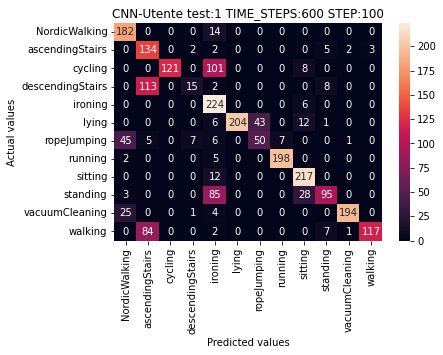

Utente test:  2
[[[[ 9.26564325e-01]
   [ 8.34300831e-01]
   [ 3.81469345e-01]
   ...
   [-2.41670834e-01]
   [-2.93414243e-01]
   [-2.40088961e-01]]

  [[ 9.35976554e-01]
   [ 7.31259141e-01]
   [ 4.11169045e-01]
   ...
   [-2.41670833e-01]
   [-2.93414233e-01]
   [-2.40088954e-01]]

  [[ 9.35846408e-01]
   [ 6.41098724e-01]
   [ 4.26052916e-01]
   ...
   [-2.41670831e-01]
   [-2.93414204e-01]
   [-2.40088932e-01]]

  ...

  [[ 3.31722751e-01]
   [ 8.78939143e-01]
   [ 3.16666391e-01]
   ...
   [-2.41650026e-01]
   [-2.89642428e-01]
   [-2.38469122e-01]]

  [[ 2.80652875e-01]
   [ 9.05220069e-01]
   [ 3.08115962e-01]
   ...
   [-2.41649763e-01]
   [-2.89629403e-01]
   [-2.38462721e-01]]

  [[ 2.98193066e-01]
   [ 8.98231311e-01]
   [ 2.64900762e-01]
   ...
   [-2.41649456e-01]
   [-2.89616118e-01]
   [-2.38456363e-01]]]


 [[[ 8.22352067e-01]
   [ 3.92171809e-01]
   [ 5.91674955e-01]
   ...
   [-2.41663777e-01]
   [-2.93334312e-01]
   [-2.40001866e-01]]

  [[ 8.52257319e-01]
   [ 5.40

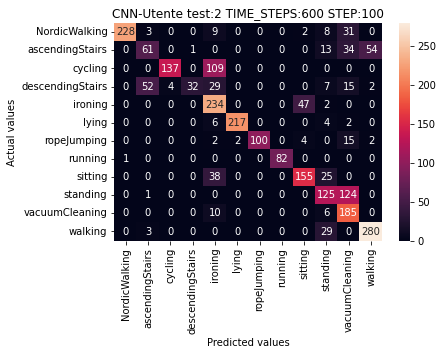

Utente test:  3
[[[[ 9.69615297e-01]
   [ 8.62654598e-01]
   [ 3.92320072e-01]
   ...
   [-2.38931020e-01]
   [-3.10342995e-01]
   [-2.20405427e-01]]

  [[ 9.79297280e-01]
   [ 7.53668117e-01]
   [ 4.21123926e-01]
   ...
   [-2.38931019e-01]
   [-3.10342984e-01]
   [-2.20405420e-01]]

  [[ 9.79163404e-01]
   [ 6.58306069e-01]
   [ 4.35558847e-01]
   ...
   [-2.38931018e-01]
   [-3.10342956e-01]
   [-2.20405398e-01]]

  ...

  [[ 3.57725631e-01]
   [ 9.09868232e-01]
   [ 3.29471801e-01]
   ...
   [-2.38910577e-01]
   [-3.06545699e-01]
   [-2.18804330e-01]]

  [[ 3.05192099e-01]
   [ 9.37665384e-01]
   [ 3.21179283e-01]
   ...
   [-2.38910319e-01]
   [-3.06532586e-01]
   [-2.18798003e-01]]

  [[ 3.23234990e-01]
   [ 9.30273423e-01]
   [ 2.79267604e-01]
   ...
   [-2.38910017e-01]
   [-3.06519212e-01]
   [-2.18791718e-01]]]


 [[[ 8.62416328e-01]
   [ 3.95017797e-01]
   [ 5.96185148e-01]
   ...
   [-2.38924087e-01]
   [-3.10262524e-01]
   [-2.20319340e-01]]

  [[ 8.93178661e-01]
   [ 5.52

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


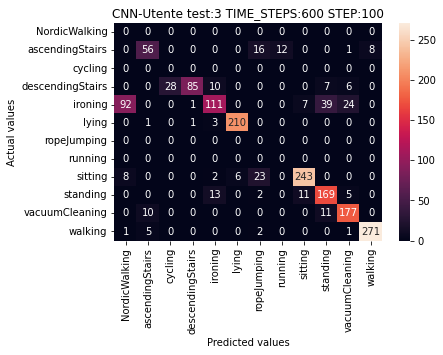

Utente test:  4
[[[[ 8.96750979e-01]
   [ 8.37620127e-01]
   [ 3.98857896e-01]
   ...
   [-2.25596192e-01]
   [-3.22791067e-01]
   [-2.19859195e-01]]

  [[ 9.06015045e-01]
   [ 7.29790888e-01]
   [ 4.27554759e-01]
   ...
   [-2.25596192e-01]
   [-3.22791057e-01]
   [-2.19859187e-01]]

  [[ 9.05886948e-01]
   [ 6.35441417e-01]
   [ 4.41936061e-01]
   ...
   [-2.25596190e-01]
   [-3.22791029e-01]
   [-2.19859163e-01]]

  ...

  [[ 3.11273109e-01]
   [ 8.84332435e-01]
   [ 3.36243074e-01]
   ...
   [-2.25574986e-01]
   [-3.19199001e-01]
   [-2.18136743e-01]]

  [[ 2.61007151e-01]
   [ 9.11834431e-01]
   [ 3.27981358e-01]
   ...
   [-2.25574717e-01]
   [-3.19186596e-01]
   [-2.18129937e-01]]

  [[ 2.78271233e-01]
   [ 9.04520960e-01]
   [ 2.86225360e-01]
   ...
   [-2.25574405e-01]
   [-3.19173945e-01]
   [-2.18123176e-01]]]


 [[[ 7.94179179e-01]
   [ 3.74948799e-01]
   [ 6.01965719e-01]
   ...
   [-2.25589000e-01]
   [-3.22714945e-01]
   [-2.19766582e-01]]

  [[ 8.23613677e-01]
   [ 5.30

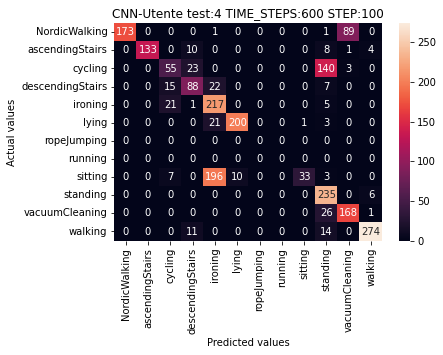

Utente test:  5
[[[[ 1.00687245e+00]
   [ 9.14829949e-01]
   [ 3.77166735e-01]
   ...
   [-2.39081654e-01]
   [-3.02870877e-01]
   [-2.18414445e-01]]

  [[ 1.01673842e+00]
   [ 8.02820927e-01]
   [ 4.05457616e-01]
   ...
   [-2.39081654e-01]
   [-3.02870865e-01]
   [-2.18414437e-01]]

  [[ 1.01660200e+00]
   [ 7.04814188e-01]
   [ 4.19635463e-01]
   ...
   [-2.39081652e-01]
   [-3.02870834e-01]
   [-2.18414413e-01]]

  ...

  [[ 3.83355534e-01]
   [ 9.63352966e-01]
   [ 3.15437740e-01]
   ...
   [-2.39062902e-01]
   [-2.98711736e-01]
   [-2.16685973e-01]]

  [[ 3.29823749e-01]
   [ 9.91921021e-01]
   [ 3.07292904e-01]
   ...
   [-2.39062665e-01]
   [-2.98697374e-01]
   [-2.16679143e-01]]

  [[ 3.48209494e-01]
   [ 9.84324058e-01]
   [ 2.66127638e-01]
   ...
   [-2.39062389e-01]
   [-2.98682725e-01]
   [-2.16672358e-01]]]


 [[[ 8.97636468e-01]
   [ 4.34224098e-01]
   [ 5.77401142e-01]
   ...
   [-2.39075295e-01]
   [-3.02782738e-01]
   [-2.18321509e-01]]

  [[ 9.28983353e-01]
   [ 5.95

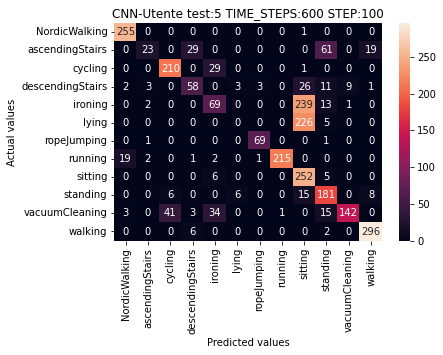

Utente test:  6
[[[[ 9.68692543e-01]
   [ 8.82876543e-01]
   [ 4.03736202e-01]
   ...
   [-2.28823618e-01]
   [-3.20798249e-01]
   [-2.30124071e-01]]

  [[ 9.78467039e-01]
   [ 7.70961289e-01]
   [ 4.32992071e-01]
   ...
   [-2.28823617e-01]
   [-3.20798238e-01]
   [-2.30124063e-01]]

  [[ 9.78331884e-01]
   [ 6.73036596e-01]
   [ 4.47653517e-01]
   ...
   [-2.28823615e-01]
   [-3.20798208e-01]
   [-2.30124040e-01]]

  ...

  [[ 3.50956156e-01]
   [ 9.31358940e-01]
   [ 3.39901661e-01]
   ...
   [-2.28802151e-01]
   [-3.16838769e-01]
   [-2.28387950e-01]]

  [[ 2.97920656e-01]
   [ 9.59903080e-01]
   [ 3.31479009e-01]
   ...
   [-2.28801879e-01]
   [-3.16825095e-01]
   [-2.28381090e-01]]

  [[ 3.16135950e-01]
   [ 9.52312476e-01]
   [ 2.88909617e-01]
   ...
   [-2.28801563e-01]
   [-3.16811150e-01]
   [-2.28374275e-01]]]


 [[[ 8.60469268e-01]
   [ 4.02673030e-01]
   [ 6.10800506e-01]
   ...
   [-2.28816338e-01]
   [-3.20714341e-01]
   [-2.30030724e-01]]

  [[ 8.91525540e-01]
   [ 5.63

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


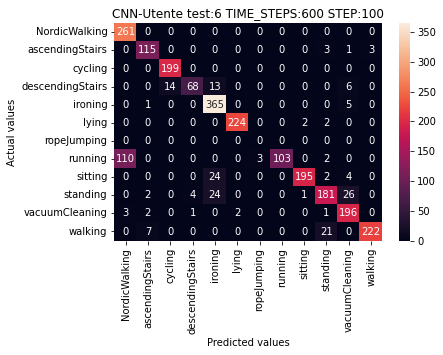

Utente test:  7
[[[[ 9.46327046e-01]
   [ 8.29360370e-01]
   [ 3.86651682e-01]
   ...
   [-2.36323779e-01]
   [-3.07311956e-01]
   [-2.24118971e-01]]

  [[ 9.55829997e-01]
   [ 7.25249639e-01]
   [ 4.16483784e-01]
   ...
   [-2.36323778e-01]
   [-3.07311945e-01]
   [-2.24118964e-01]]

  [[ 9.55698597e-01]
   [ 6.34153822e-01]
   [ 4.31434006e-01]
   ...
   [-2.36323777e-01]
   [-3.07311918e-01]
   [-2.24118941e-01]]

  ...

  [[ 3.45751960e-01]
   [ 8.74461797e-01]
   [ 3.21559835e-01]
   ...
   [-2.36304235e-01]
   [-3.03696282e-01]
   [-2.22476934e-01]]

  [[ 2.94189837e-01]
   [ 9.01015383e-01]
   [ 3.12971288e-01]
   ...
   [-2.36303987e-01]
   [-3.03683796e-01]
   [-2.22470445e-01]]

  [[ 3.11899093e-01]
   [ 8.93954118e-01]
   [ 2.69563435e-01]
   ...
   [-2.36303699e-01]
   [-3.03671061e-01]
   [-2.22464000e-01]]]


 [[[ 8.41110316e-01]
   [ 3.82644330e-01]
   [ 5.97794391e-01]
   ...
   [-2.36317151e-01]
   [-3.07235333e-01]
   [-2.24030683e-01]]

  [[ 8.71303816e-01]
   [ 5.32

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


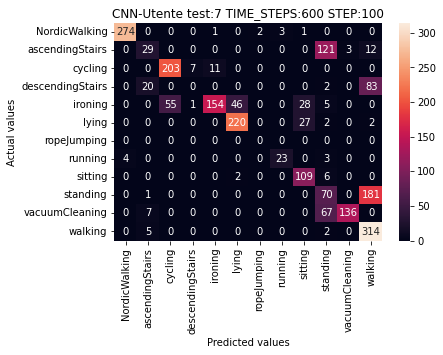

Utente test:  8
[[[[ 9.43047118e-01]
   [ 8.80280075e-01]
   [ 3.85308048e-01]
   ...
   [-2.32461779e-01]
   [-3.33917428e-01]
   [-2.30443475e-01]]

  [[ 9.52523463e-01]
   [ 7.50343450e-01]
   [ 4.14725649e-01]
   ...
   [-2.32461779e-01]
   [-3.33917418e-01]
   [-2.30443467e-01]]

  [[ 9.52392431e-01]
   [ 6.36650243e-01]
   [ 4.29468147e-01]
   ...
   [-2.32461777e-01]
   [-3.33917389e-01]
   [-2.30443443e-01]]

  ...

  [[ 3.44153499e-01]
   [ 9.36569443e-01]
   [ 3.21120617e-01]
   ...
   [-2.32440912e-01]
   [-3.30149938e-01]
   [-2.28714216e-01]]

  [[ 2.92735738e-01]
   [ 9.69709959e-01]
   [ 3.12651403e-01]
   ...
   [-2.32440648e-01]
   [-3.30136928e-01]
   [-2.28707383e-01]]

  [[ 3.10395412e-01]
   [ 9.60897064e-01]
   [ 2.69846678e-01]
   ...
   [-2.32440340e-01]
   [-3.30123659e-01]
   [-2.28700595e-01]]]


 [[[ 8.38124969e-01]
   [ 3.22750858e-01]
   [ 5.93517045e-01]
   ...
   [-2.32454703e-01]
   [-3.33837589e-01]
   [-2.30350496e-01]]

  [[ 8.68233935e-01]
   [ 5.09

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0     0.6585    0.0957    0.1672       282
           1     0.7778    0.0667    0.1228       105
           2     0.1930    0.9759    0.3223       249
           3     0.3333    0.8256    0.4749        86
           4     0.1961    0.0309    0.0533       324
           5     0.5461    0.9534    0.6944       236
           6     0.0000    0.0000    0.0000        82
           7     0.9189    0.8608    0.8889       158
           8     1.0000    0.0045    0.0089       223
           9     0.0000    0.0000    0.0000       246
          10     0.3069    0.1308    0.1834       237
          11     0.9329    0.9115    0.9221       305

    accuracy                         0.4062      2533
   macro avg     0.4886    0.4046    0.3199      2533
weighted avg     0.4982    0.4062    0.3275      2533



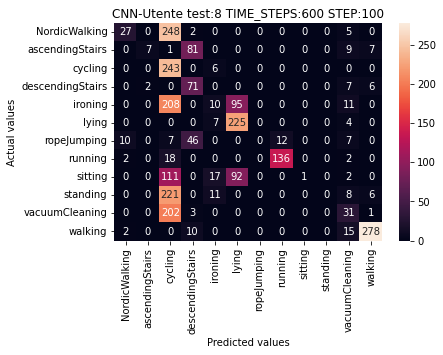

Utente test:  9
[[[[ 0.9621293 ]
   [ 0.88434928]
   [ 0.38946689]
   ...
   [-0.23487269]
   [-0.31016168]
   [-0.22499976]]

  [[ 0.97175241]
   [ 0.7720134 ]
   [ 0.41859905]
   ...
   [-0.23487269]
   [-0.31016167]
   [-0.22499975]]

  [[ 0.97161935]
   [ 0.67372066]
   [ 0.43319849]
   ...
   [-0.23487269]
   [-0.31016164]
   [-0.22499973]]

  ...

  [[ 0.35396009]
   [ 0.93301389]
   [ 0.32590229]
   ...
   [-0.23485222]
   [-0.30628985]
   [-0.22330134]]

  [[ 0.30174598]
   [ 0.96166531]
   [ 0.31751526]
   ...
   [-0.23485196]
   [-0.30627648]
   [-0.22329462]]

  [[ 0.31967917]
   [ 0.95404618]
   [ 0.27512588]
   ...
   [-0.23485166]
   [-0.30626285]
   [-0.22328796]]]


 [[[ 0.85558213]
   [ 0.40234096]
   [ 0.59565558]
   ...
   [-0.23486575]
   [-0.31007963]
   [-0.22490844]]

  [[ 0.88615742]
   [ 0.56419934]
   [ 0.65286687]
   ...
   [-0.23486567]
   [-0.31007833]
   [-0.22490644]]

  [[ 0.88753322]
   [ 0.60681238]
   [ 0.70269965]
   ...
   [-0.23486558]
   [-0.31007

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

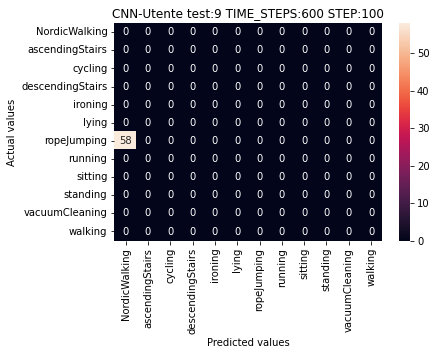

Accuracy media: 0.6211492712973173
F1 weighted media: 0.60538473148624
F1 macro media: 0.5522024098765509
   Time Steps  Step  Average accuracy  Average F1 Weighted  Average F1 Macro  \
0         600   100          0.621149             0.605385          0.552202   

                                             reports  \
0  [              precision    recall  f1-score  ...   

                                    confusion_matrix  
0  [AxesSubplot(0.125,0.125;0.62x0.755), AxesSubp...  


In [ ]:
import itertools
import gc
from tabnanny import verbose
from tkinter import Y
batchsize=128

if leave_one_subject_out:
    cnn_results_dict = []
    cnn_results = pd.DataFrame()
    try:
        mkdir(cnn_dir + leave_one_subject_out_dir)
        mkdir(cnn_dir + leave_one_subject_out_dir + plot_dir)
    except OSError as error:
        print(error)

    for config in itertools.product(time_steps_list, step_list):

        time_step = config[0]
        step=config[1]

        cnn_f1_macro = []
        cnn_f1_weighted = []
        cnn_acc = []
        cnn_class_reports = []
        cnn_confusion_matrixes = []

        print(time_step,step)

        for user_id in users_ids:

            print("Utente test: ", user_id)

            X_test = np.array(data_cnn[time_step][step][user_id][0])
            y_test = np.array(data_cnn[time_step][step][user_id][1])

            X_train = []
            y_train = []

            for id in users_ids:
                if not id == user_id:
                    X_train += data_cnn[time_step][step][id][0]
                    y_train += data_cnn[time_step][step][id][1]
            
            X_train = np.array(X_train)
            y_train = np.array(y_train)

            scaler = RobustScaler()
            X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
            X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

            y_train = enc.transform(y_train)
            y_test = enc.transform(y_test)

            X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
            X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

      #      print(X_train)
       #     print(y_train)
        #    print(X_test)

         #   print(y_test)

            model = createCNN(X_train[0].shape, y_train[0].shape[0])

            callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

            XTraining, XValidation, YTraining, YValidation = train_test_split(X_train,y_train,stratify=y_train,test_size=0.2)

            print("Training: x->",len(XTraining),"y->",len(YTraining))
            print("Validation: x->",len(XValidation),"y->",len(YValidation))
            print("Testing: x->",len(X_test),"y->",len(y_test))
            print("Total: x->",len(XTraining)+len(XValidation)+len(X_test),"y->",len(YTraining)+len(YValidation)+len(y_test))

            model.fit(XTraining, YTraining, batch_size = batchsize, epochs = 100, validation_data=(XValidation,YValidation), verbose=1, callbacks=[callback], shuffle=True, workers=10, use_multiprocessing=True )

            rounded_labels=np.argmax(y_test, axis=1)
            y_pred = np.argmax(model.predict(X_test), axis=-1)

            cnn_acc.append(accuracy_score(rounded_labels, y_pred))
            cnn_f1_weighted.append(f1_score(rounded_labels, y_pred, average='weighted'))
            cnn_f1_macro.append(f1_score(rounded_labels, y_pred, average='macro'))
            #cnn_f1.append(f1_m(rounded_labels,y_pred))

            class_report = classification_report(rounded_labels, y_pred, digits=4)
            print(class_report)
            cnn_class_reports.append(class_report)
            
            conf_matrix = confusion_matrix(rounded_labels, y_pred, labels=range(0,len(enc.categories_[0])))

            ax = seaborn.heatmap(conf_matrix, annot=True, fmt='d')

            ax.set_title("CNN-Utente test:" + str(user_id) + " TIME_STEPS:"+str(time_step)+" STEP:"+str(step))

            ax.set_xlabel('Predicted values')
            ax.set_ylabel('Actual values')

            ax.xaxis.set_ticklabels(enc.categories_[0].tolist(), rotation=90)
            ax.yaxis.set_ticklabels(enc.categories_[0].tolist(), rotation=0)

            ax.get_figure().savefig(cnn_dir + leave_one_subject_out_dir + plot_dir +'/'+ax.get_title().replace(":"," ")+".png", dpi=500)
            #model_history_file=open(cnn_dir+'/'+ax.get_title().replace(":"," ")+".txt", "w")
            #model_history_file.write(model.history())
            #model_history_file.close()

            cnn_confusion_matrixes.append(ax)
            plt.show()

            gc.collect()            

        print("Accuracy media:",np.mean(cnn_acc))
        print("F1 weighted media:",np.mean(cnn_f1_weighted))
        print("F1 macro media:",np.mean(cnn_f1_macro))

        cnn_results_dict.append({
            'Time Steps':time_step,
            'Step':step,
            'Average accuracy':np.mean(cnn_acc),
            'Average F1 Weighted': np.mean(cnn_f1_weighted),
            'Average F1 Macro': np.mean(cnn_f1_macro),
            'reports':cnn_class_reports,
            'confusion_matrix':cnn_confusion_matrixes
        })
        
        cnn_results = pd.DataFrame(cnn_results_dict)
        print(cnn_results)
        cnn_results.to_csv(cnn_dir + leave_one_subject_out_dir + result_filename)


In [ ]:
print(np.unique(y_pred))
print(np.unique(y_test))

[0]
[0. 1.]


# Bi-LSTM

In [ ]:
bilstm_dir = folder_name + "\\bilstm"
bilstm_plot_dir = bilstm_dir + "\\plot"
bilstm_result_filename = bilstm_dir + "\\result.csv"
bilstm_config_filename = bilstm_dir + "\\config_bilstm.txt"

mkdir(bilstm_dir)
mkdir(bilstm_plot_dir)

In [ ]:
def createBiLSTM(input_size, output_size):
    model = Sequential()
    model.add(Bidirectional(LSTM(units=64, return_sequences=True, input_shape=input_size)))
    model.add(Dropout(rate=0.2))
    model.add(Bidirectional(LSTM(units=64)))
    model.add(Dropout(rate=0.2))

    model.add(Dense(units=64, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(output_size, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


    
    return model

In [ ]:
data_cnn = tuple_by_timestep

600 100
Utente test:  1
Epoch 1/100
102/102 [==============================] - 22s 134ms/step - loss: 1.3553 - accuracy: 0.5347 - val_loss: 0.6827 - val_accuracy: 0.7546
Epoch 2/100
102/102 [==============================] - 12s 119ms/step - loss: 0.7702 - accuracy: 0.7356 - val_loss: 0.6234 - val_accuracy: 0.7834
Epoch 3/100
102/102 [==============================] - 13s 132ms/step - loss: 0.6258 - accuracy: 0.7879 - val_loss: 0.4271 - val_accuracy: 0.8447
Epoch 4/100
102/102 [==============================] - 12s 120ms/step - loss: 0.5017 - accuracy: 0.8305 - val_loss: 0.3379 - val_accuracy: 0.8842
Epoch 5/100
102/102 [==============================] - 12s 120ms/step - loss: 0.4135 - accuracy: 0.8580 - val_loss: 0.4089 - val_accuracy: 0.8407
Epoch 6/100
102/102 [==============================] - 12s 119ms/step - loss: 0.5192 - accuracy: 0.8224 - val_loss: 0.3578 - val_accuracy: 0.8689
Epoch 7/100
102/102 [==============================] - 12s 119ms/step - loss: 0.4109 - accuracy: 0.8

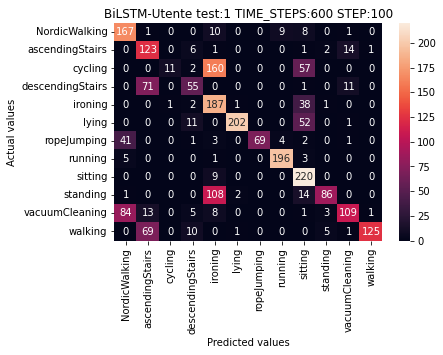

Utente test:  2
Epoch 1/100
102/102 [==============================] - 21s 137ms/step - loss: 1.3622 - accuracy: 0.5328 - val_loss: 0.6444 - val_accuracy: 0.7682
Epoch 2/100
102/102 [==============================] - 12s 121ms/step - loss: 0.7604 - accuracy: 0.7404 - val_loss: 0.5243 - val_accuracy: 0.8025
Epoch 3/100
102/102 [==============================] - 12s 121ms/step - loss: 0.6130 - accuracy: 0.7978 - val_loss: 0.4779 - val_accuracy: 0.8340
Epoch 4/100
102/102 [==============================] - 12s 121ms/step - loss: 0.5842 - accuracy: 0.8051 - val_loss: 0.4701 - val_accuracy: 0.8373
Epoch 5/100
102/102 [==============================] - 12s 119ms/step - loss: 0.5193 - accuracy: 0.8260 - val_loss: 0.3805 - val_accuracy: 0.8664
Epoch 6/100
102/102 [==============================] - 12s 120ms/step - loss: 0.4887 - accuracy: 0.8399 - val_loss: 0.4811 - val_accuracy: 0.8429
Epoch 7/100
102/102 [==============================] - 12s 120ms/step - loss: 0.5268 - accuracy: 0.8295 - va

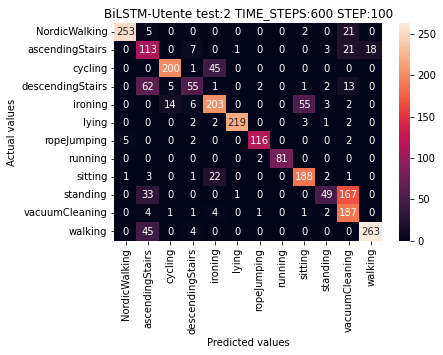

Utente test:  3
Epoch 1/100
107/107 [==============================] - 21s 137ms/step - loss: 1.3879 - accuracy: 0.5179 - val_loss: 0.7698 - val_accuracy: 0.7261
Epoch 2/100
107/107 [==============================] - 13s 121ms/step - loss: 0.8160 - accuracy: 0.7179 - val_loss: 0.6407 - val_accuracy: 0.7701
Epoch 3/100
107/107 [==============================] - 13s 121ms/step - loss: 0.6602 - accuracy: 0.7718 - val_loss: 0.5160 - val_accuracy: 0.8082
Epoch 4/100
107/107 [==============================] - 13s 121ms/step - loss: 0.5698 - accuracy: 0.8068 - val_loss: 0.4428 - val_accuracy: 0.8261
Epoch 5/100
107/107 [==============================] - 13s 121ms/step - loss: 0.5260 - accuracy: 0.8215 - val_loss: 0.4161 - val_accuracy: 0.8463
Epoch 6/100
107/107 [==============================] - 13s 120ms/step - loss: 0.4521 - accuracy: 0.8453 - val_loss: 0.3413 - val_accuracy: 0.8792
Epoch 7/100
107/107 [==============================] - 13s 121ms/step - loss: 0.4959 - accuracy: 0.8314 - va

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


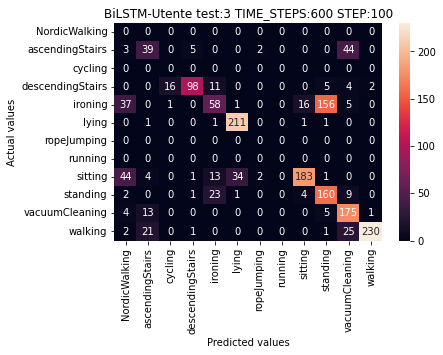

Utente test:  4
Epoch 1/100
104/104 [==============================] - 21s 142ms/step - loss: 1.3826 - accuracy: 0.5317 - val_loss: 0.7514 - val_accuracy: 0.7440
Epoch 2/100
104/104 [==============================] - 13s 122ms/step - loss: 0.8628 - accuracy: 0.7006 - val_loss: 0.5455 - val_accuracy: 0.7943
Epoch 3/100
104/104 [==============================] - 13s 122ms/step - loss: 0.6625 - accuracy: 0.7755 - val_loss: 0.5166 - val_accuracy: 0.8204
Epoch 4/100
104/104 [==============================] - 14s 136ms/step - loss: 0.5590 - accuracy: 0.8052 - val_loss: 0.6828 - val_accuracy: 0.7825
Epoch 5/100
104/104 [==============================] - 13s 123ms/step - loss: 0.8569 - accuracy: 0.7023 - val_loss: 0.6904 - val_accuracy: 0.7473
Epoch 6/100
104/104 [==============================] - 13s 122ms/step - loss: 0.6643 - accuracy: 0.7672 - val_loss: 0.4865 - val_accuracy: 0.8055
Epoch 7/100
104/104 [==============================] - 13s 122ms/step - loss: 0.6200 - accuracy: 0.7808 - va

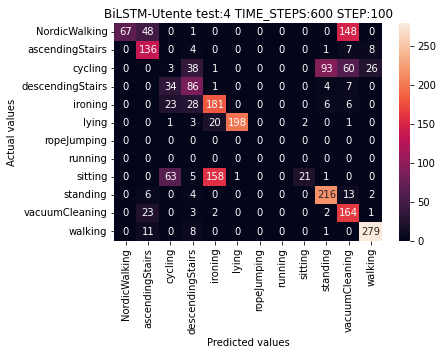

Utente test:  5
Epoch 1/100
101/101 [==============================] - 21s 140ms/step - loss: 1.3993 - accuracy: 0.5160 - val_loss: 0.8190 - val_accuracy: 0.7037
Epoch 2/100
101/101 [==============================] - 13s 125ms/step - loss: 0.8082 - accuracy: 0.7237 - val_loss: 0.5657 - val_accuracy: 0.7975
Epoch 3/100
101/101 [==============================] - 12s 124ms/step - loss: 0.6409 - accuracy: 0.7853 - val_loss: 0.5699 - val_accuracy: 0.7907
Epoch 4/100
101/101 [==============================] - 12s 123ms/step - loss: 0.5820 - accuracy: 0.8069 - val_loss: 0.4278 - val_accuracy: 0.8444
Epoch 5/100
101/101 [==============================] - 12s 123ms/step - loss: 0.5003 - accuracy: 0.8327 - val_loss: 0.3639 - val_accuracy: 0.8562
Epoch 6/100
101/101 [==============================] - 13s 125ms/step - loss: 0.5029 - accuracy: 0.8324 - val_loss: 0.5431 - val_accuracy: 0.7966
Epoch 7/100
101/101 [==============================] - 14s 138ms/step - loss: 0.4454 - accuracy: 0.8521 - va

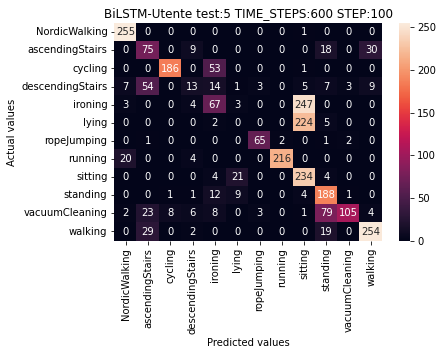

Utente test:  6
Epoch 1/100
102/102 [==============================] - 21s 143ms/step - loss: 1.4760 - accuracy: 0.4788 - val_loss: 0.8362 - val_accuracy: 0.6944
Epoch 2/100
102/102 [==============================] - 13s 127ms/step - loss: 0.8680 - accuracy: 0.6889 - val_loss: 0.5619 - val_accuracy: 0.7860
Epoch 3/100
102/102 [==============================] - 13s 129ms/step - loss: 0.6974 - accuracy: 0.7561 - val_loss: 0.5017 - val_accuracy: 0.8020
Epoch 4/100
102/102 [==============================] - 13s 127ms/step - loss: 0.7106 - accuracy: 0.7499 - val_loss: 0.7180 - val_accuracy: 0.7272
Epoch 5/100
102/102 [==============================] - 13s 126ms/step - loss: 0.7021 - accuracy: 0.7526 - val_loss: 0.5634 - val_accuracy: 0.7762
Epoch 6/100
102/102 [==============================] - 13s 125ms/step - loss: 0.6124 - accuracy: 0.7865 - val_loss: 0.5545 - val_accuracy: 0.7891
Epoch 7/100
102/102 [==============================] - 13s 126ms/step - loss: 0.6109 - accuracy: 0.7841 - va

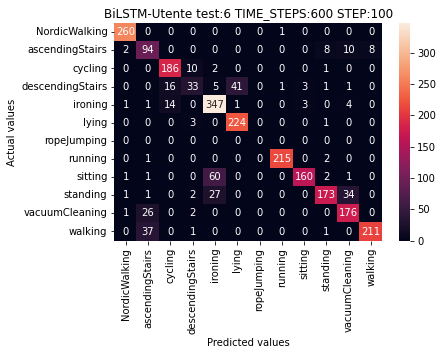

Utente test:  7
Epoch 1/100
104/104 [==============================] - 22s 142ms/step - loss: 1.3605 - accuracy: 0.5387 - val_loss: 0.6677 - val_accuracy: 0.7708
Epoch 2/100
104/104 [==============================] - 14s 138ms/step - loss: 0.7258 - accuracy: 0.7587 - val_loss: 0.5745 - val_accuracy: 0.8011
Epoch 3/100
104/104 [==============================] - 13s 127ms/step - loss: 0.6860 - accuracy: 0.7693 - val_loss: 0.4380 - val_accuracy: 0.8435
Epoch 4/100
104/104 [==============================] - 13s 126ms/step - loss: 0.5676 - accuracy: 0.8172 - val_loss: 0.4579 - val_accuracy: 0.8466
Epoch 5/100
104/104 [==============================] - 13s 127ms/step - loss: 0.5079 - accuracy: 0.8317 - val_loss: 0.3862 - val_accuracy: 0.8708
Epoch 6/100
104/104 [==============================] - 13s 126ms/step - loss: 0.4799 - accuracy: 0.8417 - val_loss: 0.4622 - val_accuracy: 0.8393
Epoch 7/100
104/104 [==============================] - 13s 127ms/step - loss: 0.7402 - accuracy: 0.7518 - va

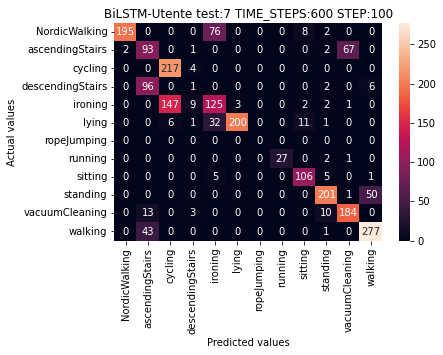

Utente test:  8
Epoch 1/100
102/102 [==============================] - 21s 144ms/step - loss: 1.4130 - accuracy: 0.5062 - val_loss: 0.7800 - val_accuracy: 0.7101
Epoch 2/100
102/102 [==============================] - 13s 127ms/step - loss: 0.8477 - accuracy: 0.7069 - val_loss: 0.6121 - val_accuracy: 0.7740
Epoch 3/100
102/102 [==============================] - 13s 127ms/step - loss: 0.7170 - accuracy: 0.7508 - val_loss: 0.5475 - val_accuracy: 0.8061
Epoch 4/100
102/102 [==============================] - 13s 128ms/step - loss: 0.7640 - accuracy: 0.7433 - val_loss: 0.5298 - val_accuracy: 0.8092
Epoch 5/100
102/102 [==============================] - 14s 137ms/step - loss: 0.5653 - accuracy: 0.8029 - val_loss: 0.4071 - val_accuracy: 0.8558
Epoch 6/100
102/102 [==============================] - 13s 127ms/step - loss: 0.5327 - accuracy: 0.8202 - val_loss: 0.3761 - val_accuracy: 0.8762
Epoch 7/100
102/102 [==============================] - 13s 126ms/step - loss: 0.5044 - accuracy: 0.8284 - va

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0     1.0000    0.0213    0.0417       282
           1     0.0000    0.0000    0.0000       105
           2     0.4142    0.9398    0.5749       249
           3     0.1389    0.9884    0.2436        86
           4     0.0000    0.0000    0.0000       324
           5     0.3179    0.9915    0.4815       236
           6     0.0000    0.0000    0.0000        82
           7     0.7914    0.9367    0.8580       158
           8     0.0000    0.0000    0.0000       223
           9     0.0000    0.0000    0.0000       246
          10     0.1818    0.0084    0.0161       237
          11     0.6600    0.7574    0.7053       305

    accuracy                         0.3711      2533
   macro avg     0.2920    0.3870    0.2434      2533
weighted avg     0.3322    0.3711    0.2542      2533



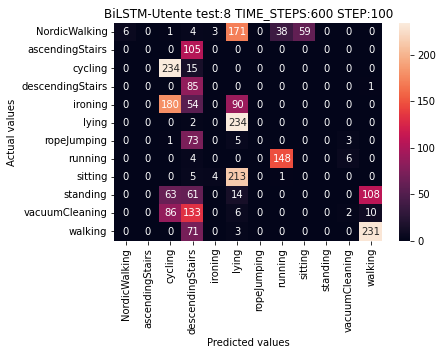

Utente test:  9
Epoch 1/100
117/117 [==============================] - 23s 141ms/step - loss: 1.3023 - accuracy: 0.5445 - val_loss: 0.7204 - val_accuracy: 0.7400
Epoch 2/100
117/117 [==============================] - 15s 127ms/step - loss: 0.7481 - accuracy: 0.7444 - val_loss: 0.5547 - val_accuracy: 0.7962
Epoch 3/100
117/117 [==============================] - 15s 127ms/step - loss: 0.6829 - accuracy: 0.7639 - val_loss: 0.5091 - val_accuracy: 0.8257
Epoch 4/100
117/117 [==============================] - 15s 127ms/step - loss: 0.7461 - accuracy: 0.7418 - val_loss: 0.5015 - val_accuracy: 0.8243
Epoch 5/100
117/117 [==============================] - 22s 189ms/step - loss: 0.5879 - accuracy: 0.7980 - val_loss: 0.5052 - val_accuracy: 0.8163
Epoch 6/100
117/117 [==============================] - 15s 132ms/step - loss: 0.6692 - accuracy: 0.7699 - val_loss: 0.5523 - val_accuracy: 0.7973
Epoch 7/100
117/117 [==============================] - 17s 141ms/step - loss: 0.5686 - accuracy: 0.8052 - va

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

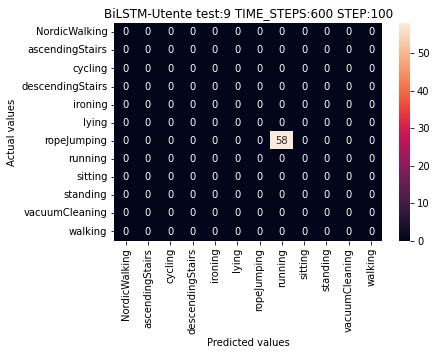

Accuracy media: 0.5872453503931815
F1 media macro: 0.5336902917589379
F1 media weighted: 0.5336902917589379


In [ ]:
import itertools
import gc
bilstm_results_dict = []
bilstm_results = pd.DataFrame()

if bilstm_one_subject_out:

    for config in itertools.product(time_steps_list, step_list):

        time_step = config[0]
        step=config[1]

        bilstm_f1_weighted = []
        bilstm_f1_macro = []
        bilstm_acc = []
        bilstm_class_reports = []
        bilstm_confusion_matrixes = []

        print(time_step,step)

        for user_id in users_ids:

            print("Utente test: ", user_id)

            X_test = np.array(data_cnn[time_step][step][user_id][0])
            y_test = np.array(data_cnn[time_step][step][user_id][1])

            X_train = []
            y_train = []

            for id in users_ids:
                if id != user_id:
                    X_train += data_cnn[time_step][step][id][0]
                    y_train += data_cnn[time_step][step][id][1]
            
            X_train = np.array(X_train)
            y_train = np.array(y_train)

            y_train = enc.transform(y_train)
            y_test = enc.transform(y_test)

            scaler = RobustScaler()
            X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
            X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
            
            #X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
            #X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

            model = createBiLSTM([X_train[0].shape[0], X_train[0].shape[1]], y_train[0].shape[0])

            callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=True, restore_best_weights=True)

            XTraining, XValidation, YTraining, YValidation = train_test_split(X_train,y_train,stratify=y_train,test_size=0.2)

            model.fit(XTraining, YTraining, batch_size = batchsize, epochs = 100, validation_data=(XValidation,YValidation), verbose=1, callbacks=[callback], shuffle=True )
            
            rounded_labels=np.argmax(y_test, axis=1)
            y_pred = np.argmax(model.predict(X_test), axis=-1)

            bilstm_acc.append(accuracy_score(rounded_labels, y_pred))
            bilstm_f1_weighted.append(f1_score(rounded_labels, y_pred, average='weighted'))
            bilstm_f1_macro.append(f1_score(rounded_labels, y_pred, average='macro'))
            #bilstm_f1.append(f1_m(rounded_labels,y_pred))

            class_report = classification_report(rounded_labels, y_pred, digits=4)
            print(class_report)
            bilstm_class_reports.append(class_report)
            
            conf_matrix = confusion_matrix(rounded_labels, y_pred, labels=range(0,len(enc.categories_[0])))

            ax = seaborn.heatmap(conf_matrix, annot=True, fmt='d')

            ax.set_title("BiLSTM-Utente test:" + str(user_id) + " TIME_STEPS:"+str(time_step)+" STEP:"+str(step))

            ax.set_xlabel('Predicted values')
            ax.set_ylabel('Actual values')

            ax.xaxis.set_ticklabels(enc.categories_[0].tolist(), rotation=90)
            ax.yaxis.set_ticklabels(enc.categories_[0].tolist(), rotation=0)

            ax.get_figure().savefig(bilstm_plot_dir+'/'+ax.get_title().replace(":"," ")+".png", dpi=500)

            bilstm_confusion_matrixes.append(ax)
            plt.show()

            gc.collect()





            

        print("Accuracy media:",np.mean(bilstm_acc))
        print("F1 media macro:",np.mean(bilstm_f1_macro))
        print("F1 media weighted:",np.mean(bilstm_f1_macro))

        bilstm_results_dict.append({
            'Time Steps':time_step,
            'Step':step,
            'Average accuracy':np.mean(bilstm_acc),
            'Average F1 weighted': np.mean(bilstm_f1_weighted),
            'Average F1 macro': np.mean(bilstm_f1_macro),
            'reports':bilstm_class_reports,
            'confusion_matrix':bilstm_confusion_matrixes
        })

    bilstm_config_file = open(bilstm_config_filename, "a")
    model.summary(print_fn=lambda x: bilstm_config_file.write(x))
    bilstm_config_file.close()

In [ ]:
bilstm_results_dataframe = pd.DataFrame(bilstm_results_dict)
bilstm_results_dataframe.to_csv(bilstm_result_filename)
bilstm_results_dataframe

,Time Steps,Step,Average accuracy,Average F1 weighted,Average F1 macro,reports,confusion_matrix
0,600,100,0.587245,0.562927,0.53369,[ precision recall f1-score ...,"[AxesSubplot(0.125,0.125;0.62x0.755), AxesSubp..."


# SHALLOW LEARNING

## Random Forest

In [ ]:
rf_dir = folder_name + "\\rf"
plot_dir = "\\plot"
result_filename = "\\result.csv"
config_filename = "\\config.txt"

try:
    mkdir(rf_dir )
    mkdir(rf_dir + plot_dir)
except OSError as error:
    print(error)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 15.3min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.8s finished
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Us

                  precision    recall  f1-score   support

   NordicWalking       0.31      0.59      0.40       196
 ascendingStairs       0.43      0.91      0.58       148
         cycling       0.00      0.00      0.00       230
descendingStairs       0.27      0.09      0.13       138
         ironing       0.38      0.98      0.55       230
           lying       0.90      0.96      0.93       266
     ropeJumping       0.00      0.00      0.00       121
         running       1.00      0.97      0.98       205
         sitting       0.94      0.65      0.77       229
        standing       0.85      0.56      0.68       211
  vacuumCleaning       0.59      0.58      0.58       224
         walking       1.00      0.37      0.54       211

        accuracy                           0.59      2409
       macro avg       0.55      0.55      0.51      2409
    weighted avg       0.59      0.59      0.55      2409

f1:  0.5483709324110521
acc:  0.5877957658779577


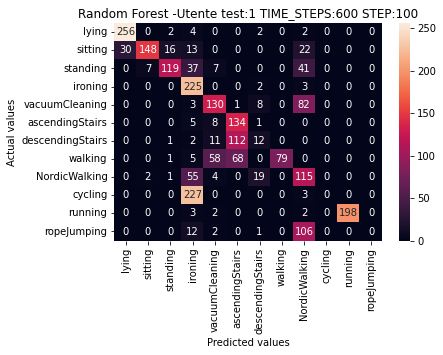

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   41.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 15.1min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.8s finished


                  precision    recall  f1-score   support

   NordicWalking       0.96      0.82      0.89       281
 ascendingStairs       0.53      0.67      0.59       163
         cycling       1.00      0.49      0.66       246
descendingStairs       0.57      0.35      0.43       141
         ironing       0.58      0.97      0.73       283
           lying       0.98      0.96      0.97       229
     ropeJumping       1.00      0.64      0.78       125
         running       0.68      0.98      0.80        83
         sitting       0.87      0.63      0.73       218
        standing       0.99      0.61      0.76       250
  vacuumCleaning       0.54      0.94      0.68       201
         walking       0.89      0.93      0.91       312

        accuracy                           0.76      2532
       macro avg       0.80      0.75      0.74      2532
    weighted avg       0.82      0.76      0.76      2532

f1:  0.7627590698071672
acc:  0.7638230647709321


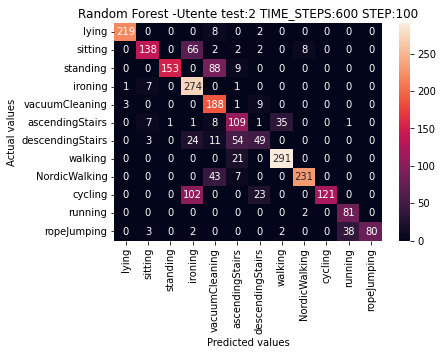

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   41.9s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 15.2min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.6s finished
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_

                  precision    recall  f1-score   support

   NordicWalking       0.00      0.00      0.00         0
 ascendingStairs       0.50      0.77      0.61        93
         cycling       0.00      0.00      0.00         0
descendingStairs       0.88      0.76      0.82       136
         ironing       0.86      0.44      0.58       274
           lying       0.82      0.96      0.88       215
     ropeJumping       0.00      0.00      0.00         0
         running       0.00      0.00      0.00         0
         sitting       0.96      0.61      0.75       282
        standing       0.82      0.73      0.77       200
  vacuumCleaning       0.85      0.80      0.82       198
         walking       1.00      0.86      0.93       280

        accuracy                           0.73      1678
       macro avg       0.56      0.50      0.51      1678
    weighted avg       0.87      0.73      0.78      1678

f1:  0.7780837044866771
acc:  0.7288438617401669


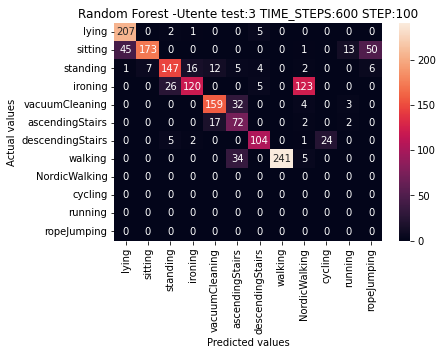

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 14.9min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.7s finished
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_

                  precision    recall  f1-score   support

   NordicWalking       1.00      0.25      0.40       264
 ascendingStairs       0.58      0.85      0.69       156
         cycling       0.52      0.58      0.55       221
descendingStairs       0.24      0.23      0.23       132
         ironing       0.47      0.85      0.61       244
           lying       1.00      0.94      0.97       225
     ropeJumping       0.00      0.00      0.00         0
         running       0.00      0.00      0.00         0
         sitting       0.32      0.02      0.04       249
        standing       0.91      0.91      0.91       241
  vacuumCleaning       0.39      0.68      0.50       195
         walking       0.89      0.87      0.88       299

        accuracy                           0.63      2226
       macro avg       0.53      0.52      0.48      2226
    weighted avg       0.67      0.63      0.60      2226

f1:  0.5950817878971503
acc:  0.6271338724168913


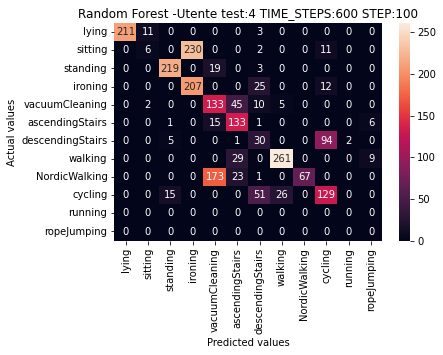

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   41.0s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 14.9min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.9s finished


                  precision    recall  f1-score   support

   NordicWalking       0.46      0.95      0.62       256
 ascendingStairs       0.56      0.83      0.66       132
         cycling       0.98      0.48      0.65       240
descendingStairs       0.20      0.20      0.20       116
         ironing       0.51      0.69      0.59       324
           lying       0.20      0.13      0.16       231
     ropeJumping       0.80      0.77      0.79        71
         running       0.74      0.08      0.15       240
         sitting       0.31      0.48      0.38       263
        standing       0.71      0.75      0.73       216
  vacuumCleaning       0.73      0.38      0.50       239
         walking       1.00      0.79      0.88       304

        accuracy                           0.55      2632
       macro avg       0.60      0.54      0.53      2632
    weighted avg       0.61      0.55      0.53      2632

f1:  0.5279671126055999
acc:  0.5467325227963525


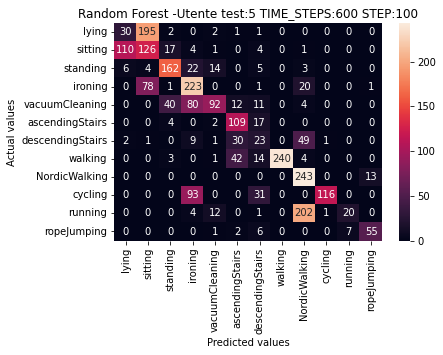

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   40.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 14.8min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.7s finished
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_

                  precision    recall  f1-score   support

   NordicWalking       0.92      1.00      0.96       261
 ascendingStairs       0.58      0.93      0.71       122
         cycling       0.75      0.98      0.85       199
descendingStairs       0.28      0.20      0.23       101
         ironing       0.79      0.75      0.77       371
           lying       0.91      0.99      0.95       228
     ropeJumping       0.00      0.00      0.00         0
         running       1.00      0.73      0.84       218
         sitting       0.99      0.86      0.92       225
        standing       0.97      0.40      0.57       238
  vacuumCleaning       0.54      0.76      0.63       205
         walking       1.00      0.86      0.93       250

        accuracy                           0.79      2418
       macro avg       0.73      0.71      0.70      2418
    weighted avg       0.84      0.79      0.79      2418

f1:  0.793306808007191
acc:  0.7911497105045492


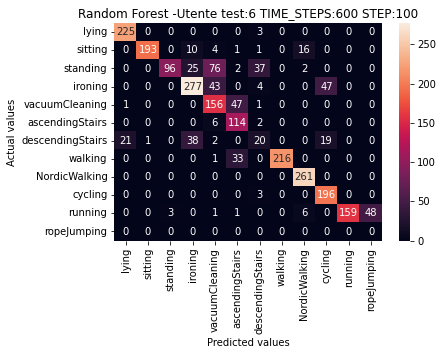

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   42.7s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 15.5min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.7s finished


                  precision    recall  f1-score   support

   NordicWalking       1.00      0.97      0.99       281
 ascendingStairs       0.42      0.77      0.55       165
         cycling       0.71      1.00      0.83       221
descendingStairs       0.00      0.00      0.00       105
         ironing       0.96      0.65      0.77       289
           lying       0.90      0.08      0.14       251
         running       1.00      0.83      0.91        30
         sitting       0.37      0.94      0.53       117
        standing       0.78      0.81      0.79       252
  vacuumCleaning       0.83      0.86      0.85       210
         walking       0.86      0.89      0.87       321

        accuracy                           0.73      2242
       macro avg       0.71      0.71      0.66      2242
    weighted avg       0.77      0.73      0.69      2242

f1:  0.6946012922586889
acc:  0.7274754683318466


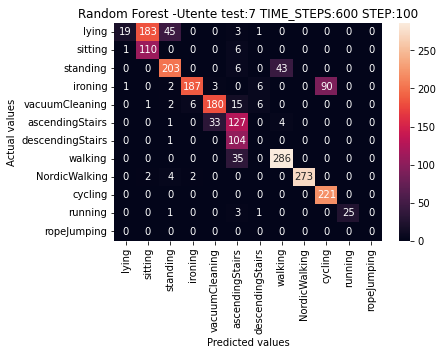

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   39.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 14.1min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.7s finished
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Us

                  precision    recall  f1-score   support

   NordicWalking       0.88      0.26      0.40       282
 ascendingStairs       0.30      0.09      0.13       105
         cycling       0.32      1.00      0.48       249
descendingStairs       0.28      0.92      0.43        86
         ironing       0.16      0.12      0.14       324
           lying       0.95      0.99      0.97       236
     ropeJumping       0.00      0.00      0.00        82
         running       0.87      0.85      0.86       158
         sitting       0.67      0.10      0.17       223
        standing       0.95      0.45      0.61       246
  vacuumCleaning       0.71      0.32      0.45       237
         walking       0.67      0.96      0.79       305

        accuracy                           0.52      2533
       macro avg       0.56      0.51      0.45      2533
    weighted avg       0.61      0.52      0.48      2533

f1:  0.48460768755360234
acc:  0.5215159889459139


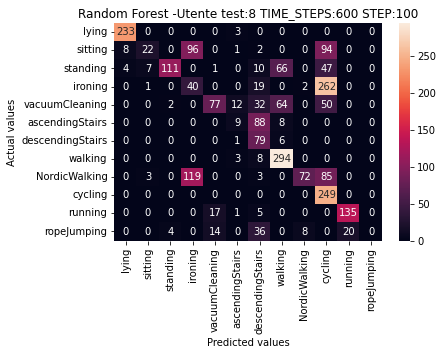

F1 total:  0.6480972993783911
Accuracy total:  0.6618087819230764
   Time Steps  Step  Average accuracy  Average F1
0         600   100          0.661809    0.648097


In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

rf_results = []

gc.collect()
for config in itertools.product(time_steps_list, step_list):



    time_step = config[0]
    step=config[1]

    tuple = tuple_by_timestep[time_steps][step]

    f1_list = []
    acc_list = []

    for user_id in users_ids:

        x_test = tuple[user_id][0]
        y_test = tuple[user_id][1]

        x_train = []
        y_train = []

        for id in users_ids:
            if id != user_id:
                x_train+=tuple[id][0]
                y_train+=tuple[id][1]
        
        x_train = [x_train[i].flatten() for i in range(len(x_train)) ]
        x_test = [x_test[i].flatten() for i in range(len(x_test))]

        y_train = np.array(y_train).flatten()
        y_test = np.array(y_test).flatten()

        scaler = MinMaxScaler()
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.transform(x_test)

        model = RandomForestClassifier(n_jobs=-1,n_estimators=1000,random_state=seed, verbose=True)

        model.fit(x_train, y_train)

        y_pred = model.predict(x_test)

        conf_mat = confusion_matrix(y_test, y_pred, labels=classes)

        f1 = f1_score(y_test, y_pred, average='weighted')
        acc = accuracy_score(y_test, y_pred)

        print(classification_report(y_test, y_pred))

        ax = seaborn.heatmap(conf_mat, annot=True, fmt='d')

        ax.set_title("Random Forest -Utente test:" + str(user_id) + " TIME_STEPS:"+str(time_step)+" STEP:"+str(step))
        ax.get_figure().savefig(rf_dir+plot_dir+'/'+ax.get_title().replace(":"," ")+".png", dpi=500)
        ax.set_xlabel('Predicted values')
        ax.set_ylabel('Actual values')

        ax.xaxis.set_ticklabels(classes, rotation=90)
        ax.yaxis.set_ticklabels(classes, rotation=0)


        print("f1: ", f1)
        print("acc: ", acc)

        f1_list.append(f1)
        acc_list.append(acc)


        plt.show()
    
    print("F1 total: ", np.mean(f1_list))
    print("Accuracy total: ", np.mean(acc_list))

    rf_results.append({
    'Time Steps':time_step,
    'Step':step,
    'Average accuracy':np.mean(acc_list),
    'Average F1': np.mean(f1_list),
    })

rf_results_df = pd.DataFrame(rf_results)
rf_results_df.to_csv(rf_dir + result_filename)
print(rf_results_df)


## SVM

In [ ]:
svm_dir = folder_name + "\\svm"
plot_dir = "\\plot"
result_filename = "\\result.csv"
config_filename = "\\config.txt"

try:
    mkdir(svm_dir )
    mkdir(svm_dir + plot_dir)
except OSError as error:
    print(error)

[LibSVM]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                  precision    recall  f1-score   support

   NordicWalking       0.36      0.55      0.44       196
 ascendingStairs       0.44      0.89      0.59       148
         cycling       0.82      0.06      0.11       230
descendingStairs       0.25      0.18      0.21       138
         ironing       0.31      0.61      0.41       230
           lying       0.85      0.98      0.91       266
     ropeJumping       0.00      0.00      0.00       121
         running       0.74      0.97      0.84       205
         sitting       0.56      0.90      0.69       229
        standing       0.36      0.17      0.23       211
  vacuumCleaning       0.76      0.32      0.45       224
         walking       0.96      0.54      0.69       211

        accuracy                           0.54      2409
       macro avg       0.54      0.51      0.46      2409
    weighted avg       0.58      0.54      0.49      2409

f1 macro:  0.46448212825785823
f1 weighted:  0.49417965705278544
acc:

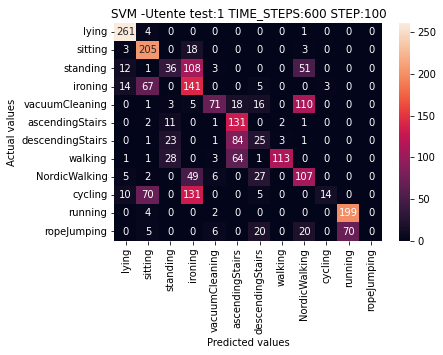

[LibSVM]

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

svm_results = []

gc.collect()
for config in itertools.product(time_steps_list, step_list):

    time_step = config[0]
    step=config[1]

    tuple = tuple_by_timestep[time_steps][step]

    f1_macro_list = []
    f1_weighted_list = []
    acc_list = []

    for user_id in users_ids:

        x_test = tuple[user_id][0]
        y_test = tuple[user_id][1]

        x_train = []
        y_train = []

        for id in users_ids:
            if id != user_id:
                x_train+=tuple[id][0]
                y_train+=tuple[id][1]
        
        x_train = [x_train[i].flatten() for i in range(len(x_train)) ]
        x_test = [x_test[i].flatten() for i in range(len(x_test))]

        y_train = np.array(y_train).flatten()
        y_test = np.array(y_test).flatten()

        scaler = MinMaxScaler()
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.transform(x_test)

        #model = RandomForestClassifier(n_jobs=-1,n_estimators=1000,random_state=seed, verbose=True)
        model = SVC(kernel='linear',random_state=seed, verbose=1)

        model.fit(x_train, y_train)

        y_pred = model.predict(x_test)

        conf_mat = confusion_matrix(y_test, y_pred, labels=classes)

        f1_w = f1_score(y_test, y_pred, average='weighted')
        f1_m = f1_score(y_test, y_pred, average='macro')
        acc = accuracy_score(y_test, y_pred)

        print(classification_report(y_test, y_pred))

        ax = seaborn.heatmap(conf_mat, annot=True, fmt='d')

        ax.set_title("SVM -Utente test:" + str(user_id) + " TIME_STEPS:"+str(time_step)+" STEP:"+str(step))
        ax.get_figure().savefig(svm_dir + plot_dir +'/'+ax.get_title().replace(":"," ")+".png", dpi=500)
        ax.set_xlabel('Predicted values')
        ax.set_ylabel('Actual values')

        ax.xaxis.set_ticklabels(classes, rotation=90)
        ax.yaxis.set_ticklabels(classes, rotation=0)


        print("f1 macro: ", f1_m)
        print("f1 weighted: ", f1_w)
        print("acc: ", acc)

        f1_macro_list.append(f1_m)
        f1_weighted_list.append(f1_w)
        acc_list.append(acc)


        plt.show()
    
    print("F1 weighted total: ", np.mean(f1_weighted_list))
    print("F1 macro total: ", np.mean(f1_macro_list))
    print("Accuracy total: ", np.mean(acc_list))

    svm_results.append({
    'Time Steps':time_step,
    'Step':step,
    'Average accuracy':np.mean(acc_list),
    'Average F1 macro': np.mean(f1_macro_list),
    'Average F1 weighted': np.mean(f1_weighted_list)
    })

svm_results_df = pd.DataFrame(svm_results)
svm_results_df.to_csv(svm_dir + result_filename)
print(svm_results_df)



In [ ]:
svm_results_df

In [ ]:
print("F1 weighted total: ", np.mean(f1_weighted_list))
print("F1 macro total: ", np.mean(f1_macro_list))
print("Accuracy total: ", np.mean(acc_list))